In [1]:

#!pip install requests_oauthlib
#!pip install twython
#!pip install nltk

In [1]:
# Módulos 

import pyspark
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
import requests_oauthlib
from requests_oauthlib import OAuth1Session
from operator import add
from time import gmtime, strftime
import requests
import time
import string
import ast
import json
import matplotlib.pylab as pl


In [2]:
# Pacote NLTK
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment import SentimentAnalyzer
from nltk.corpus import subjectivity
from nltk.corpus import stopwords
from nltk.sentiment.util import *

In [3]:
import matplotlib.pyplot as plt
from matplotlib import animation
import pandas as pd

In [5]:
config = pyspark.SparkConf().setAll([("spark.dynamicAllocation.enabled", "true"),("spark.executor.cores", 4),("spark.dynamicAllocation.minExecutors","1"),("spark.dynamicAllocation.maxExecutors","5")])
sc = pyspark.SparkContext.getOrCreate(conf=config)

In [6]:
# Frequencia de batch - 5 seg
INTERVALO_BATCH = 5

In [7]:
# Criando o StreamingContext
ssc = StreamingContext(sc, INTERVALO_BATCH)

In [8]:
# Lendo o arquivo texto e criando um RDD em memória com Spark, dataset com classificação entre twitter positivo e negativo
arquivo = sc.textFile("dataset_analise_sentimento.csv")

In [9]:
# Remover o cabeçalho
header = arquivo.take(1)[0]
dataset = arquivo.filter(lambda line: line != header)

In [10]:
#!python --version
#!pip install pyspark
#!pip install py4j

In [11]:
type(dataset)

pyspark.rdd.PipelinedRDD

In [12]:
# Separar as colunas de cada linha, cria uma tupla e remove a pontuação. Faz limpeza do tweets
def get_row(line):
  row = line.split(',')
  sentimento = row[1]
  tweet = row[3].strip()
  translator = str.maketrans({key: None for key in string.punctuation})
  tweet = tweet.translate(translator)
  tweet = tweet.split(' ')
  tweet_lower = []
  for word in tweet:
    tweet_lower.append(word.lower())
  return (tweet_lower, sentimento)

In [13]:
# Aplica a função a cada linha do dataset
dataset_treino = dataset.map(lambda line: get_row(line))

In [14]:
# Cria um objeto SentimentAnalyzer 
sentiment_analyzer = SentimentAnalyzer()

In [ ]:
# https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml
#nltk.download()
#nltk.download("stopwords")

In [ ]:
#from IPython.display import Image
#Image(url = 'ntlkdata.png')

In [15]:
# Lista de stopwords em Inglês 
stopwords_all = []
for word in stopwords.words('english'):
  stopwords_all.append(word)
  stopwords_all.append(word + '_NEG')

In [16]:
# 10.000 tweets do dataset de treino e retorna todas as palavras que não são stopwords
dataset_treino_amostra = dataset_treino.take(10000)

In [17]:
all_words_neg = sentiment_analyzer.all_words([mark_negation(doc) for doc in dataset_treino_amostra])
all_words_neg_nostops = [x for x in all_words_neg if x not in stopwords_all]

In [18]:
# Cria um unigram (n-grama) e extrai as features
unigram_feats = sentiment_analyzer.unigram_word_feats(all_words_neg_nostops, top_n = 200)
sentiment_analyzer.add_feat_extractor(extract_unigram_feats, unigrams = unigram_feats)
training_set = sentiment_analyzer.apply_features(dataset_treino_amostra)

In [19]:
type(training_set)

nltk.collections.LazyMap

In [20]:
print(training_set)

[({'contains()': False, 'contains(im)': False, 'contains(_NEG)': False, 'contains(followfriday)': False, 'contains(amp)': False, 'contains(dont)': False, 'contains(day)': False, 'contains(love)': False, 'contains(like)': False, 'contains(cant)': False, 'contains(good)': False, 'contains(get)': False, 'contains(go)': False, 'contains(today)': False, 'contains(got)': False, 'contains(want)': False, 'contains(time)': False, 'contains(going)': False, 'contains(back)': False, 'contains(one)': False, 'contains(sad)': True, 'contains(really)': False, 'contains(miss)': False, 'contains(u)': False, 'contains(work)': False, 'contains(new)': False, 'contains(2)': False, 'contains(last)': False, 'contains(still)': False, 'contains(twitter)': False, 'contains(night)': False, 'contains(great)': False, 'contains(lol)': False, 'contains(follow)': False, 'contains(need)': False, 'contains(see)': False, 'contains(much)': False, 'contains(myweakness)': False, 'contains(get_NEG)': False, 'contains(didnt)'

In [21]:
# Treinar o modelo
trainer = NaiveBayesClassifier.train
classifier = sentiment_analyzer.train(trainer, training_set)

Training classifier


In [22]:
# Testa o classificador
test_sentence1 = [(['this', 'program', 'is', 'bad'], '')]
test_sentence2 = [(['tough', 'day', 'at', 'work', 'today'], '')]
test_sentence3 = [(['good', 'wonderful', 'amazing', 'awesome'], '')]
test_set = sentiment_analyzer.apply_features(test_sentence1)
test_set2 = sentiment_analyzer.apply_features(test_sentence2)
test_set3 = sentiment_analyzer.apply_features(test_sentence3)

In [23]:
# Autenticação do Twitter 
consumer_key = "J64Q4eke1WQvkMnsGbqGXY9O4"
consumer_secret = "ixilMUmAh4Esf3mXf7dEHczazdG227dbnWh1ImfE58KHxBxD1z"
access_token = "1449972010982023170-AWAd60CKm01lnf4TD2ooBHj7xTd7rl"
access_token_secret = "xf3kd8GqpB8iUWGmzK1wzAmeuhlyFS1BNUd9LsNNqcRSa"

In [24]:
# termo de busca
search_term = 'Trump'
sample_url = 'https://stream.twitter.com/1.1/statuses/sample.json'
filter_url = 'https://stream.twitter.com/1.1/statuses/filter.json?track='+search_term

In [25]:
# Criando o objeto de atutenticação para o Twitter
auth = requests_oauthlib.OAuth1(consumer_key, consumer_secret, access_token, access_token_secret)

In [26]:
# Configurando o Stream
rdd = ssc.sparkContext.parallelize([0])
stream = ssc.queueStream([], default = rdd)

In [27]:
type(stream)

pyspark.streaming.dstream.DStream

In [28]:
# Total de tweets por update
NUM_TWEETS = 10

In [29]:
# Essa função conecta ao Twitter e retorna um número específico de Tweets (NUM_TWEETS)
def tfunc(t, rdd):
  return rdd.flatMap(lambda x: stream_twitter_data())

def stream_twitter_data():
  response = requests.get(filter_url, auth = auth, stream = True)
  print(filter_url, response)
  count = 0
  for line in response.iter_lines():
    try:
      if count > NUM_TWEETS:
        break
      post = json.loads(line.decode('utf-8'))
      contents = [post['text']]
      count += 1
      yield str(contents)
    except:
      result = False

In [30]:
stream = stream.transform(tfunc)

In [31]:
coord_stream = stream.map(lambda line: ast.literal_eval(line))

In [32]:
# Essa função classifica os tweets, aplicando as features do modelo criado anteriormente
def classifica_tweet(tweet):
  sentence = [(tweet, '')]
  test_set = sentiment_analyzer.apply_features(sentence)
  print(tweet, classifier.classify(test_set[0][0]))
  return(tweet, classifier.classify(test_set[0][0]))

In [33]:
# Essa função retorna o texto do Twitter
def get_tweet_text(rdd):
  for line in rdd:
    tweet = line.strip()
    translator = str.maketrans({key: None for key in string.punctuation})
    tweet = tweet.translate(translator)
    tweet = tweet.split(' ')
    tweet_lower = []
    for word in tweet:
      tweet_lower.append(word.lower())
    return(classifica_tweet(tweet_lower))

In [34]:
# Cria uma lista vazia para os resultados
resultados = []

In [35]:
# Essa função salva o resultado dos batches de Tweets junto com o timestamp
def output_rdd(rdd):
  global resultados
  pairs = rdd.map(lambda x: (get_tweet_text(x)[1],1))
  counts = pairs.reduceByKey(add)
  output = []
  for count in counts.collect():
    output.append(count)
  result = [time.strftime("%I:%M:%S"), output]
  resultados.append(result)
  print(result)

In [36]:
# A função foreachRDD() aplica uma função a cada RDD to streaming de dados
coord_stream.foreachRDD(lambda t, rdd: output_rdd(rdd))

In [37]:
# Start streaming
ssc.start()
# ssc.awaitTermination()

In [38]:
cont = True
while cont:
  continue

['06:58:59', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', '4theculture', 'remove', 'the', 'judge', 'immediately'] 0    (7 + 1) / 8]
['rt', 'palmerreport', 'merrick', 'garland’s', 'doj', 'has', 'criminally', 'indicted', 'steve', 'bannon', 'for', 'contempt', 'bannon', 'is', 'surrendering', 'this', 'was', 'always', 'going', 'to…'] 0
['rt', 'fearlesspac', 'trump', 'has', '11', '“wannabe’s”', 'in', 'congress', '\n\nwe’re', 'taking', 'them', 'all', 'down', '\n\nrt', 'and', 'follow', 'us', 'fearlesspac'] 1
['jimjordan', 'you', 'first', 'need', 'to', 'come', 'before', 'congress', 'and', 'explain', 'what', 'you', 'spoke', 'with', 'trump', 'on', 'jan', '6'] 0
['there', 'are', '“judges', 'appointed', 'by', 'trump”', 'and', '“trump', 'judges”', 'kyle', 'duncan—she’s', 'a', '“trump', 'judge”'] 0
['rt', 'davidcorndc', 'uh', 'when', 'was', 'the', 'last', 'time', 'congress', 'had', 'to', 'investigate', 'a', 'former', 'president', 'and', 'his', 'henchmen', 'for', 'an', 'in

['06:59:03', [('0', 10), ('1', 1)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'joncoopertweets', 'no', 'more', 'delays', 'the', 'january6thcmte', 'should', 'immediately', 'subpoena', 'donald', 'trump', '\n\nraise', 'your', 'hand', 'if', 'you', 'agree', '✋'] 0
['rt', 'stephenking', 'trump', 'is', 'never', 'going', 'to', 'jail', 'he', 'deserves', 'to', 'but', 'he’s', 'rich', 'and', 'powerful', 'instead', 'of', 'poor', 'and', 'black', 'welcome', 'to', 'america'] 0
['rt', 'steveschmidtses', 'or', 'has', 'all', 'pretense', 'of', 'reporting', 'reality', 'and', 'facts', 'just', 'completely', 'disappeared', 'is', 'that', 'what', 'conservatism', 'is', 'too', 'you…'] 0
['zerohedge', 'trump', 'kept', 'turkey', 'prices', 'low'] 0
['seanspicer', 'and', 'what', 'percent', 'took', 'new', 'jobs', 'it', 'seems', 'more', 'than', 'quit', 'them', 'since', 'the', 'jobless', 'rate', 'went', 'down', 'to', '46…', 'httpstcorojygs7ft8'] 0
['rt', 'purplerain713', 'media', 'choosing', 'ur', 'candidates'

['06:59:08', [('0', 9), ('1', 2)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'davidcorndc', 'sincere', 'question', 'trump', 'barely', 'got', 'anything', 'done', 'amp', 'killed', '100ks', 'with', 'his', 'ineptitude', 'rs', 'still', 'love', 'him', 'biden', 'got', 'a', 'handle…'] 1
['rt', 'projectlincoln', 'donald', 'trump', 'is', 'a', 'talker', '\n\njoe', 'biden', 'is', 'a', 'builder', 'httpstcobjmltogv98'] 0
['rt', 'leslibless', 'joe', 'spent', 'last', 'weekend', 'at', 'the', 'beachhe', 'leaves', 'today', 'for', 'camp', 'david', 'every', 'single', 'weekendgone\ntrump', 'would', 'go', 'away', 'once…'] 0
['rt', 'tedlieu', 'no', 'one', 'should', 'be', 'above', 'the', 'law', 'not', 'the', 'former', 'president', 'not', 'his', 'staff', 'not', 'members', 'of', 'congress', 'and', 'not', 'steve', 'bannon'] 0
['rt', 'travisbhill5', 'bro', 'what', 'is', 'the', 'onion', 'even', 'supposed', 'to', 'do', 'at', 'this', 'point'] 0
['rt', 'vermontgmg', 'not', 'for', 'nothing', 'but', 'steve', 

['06:59:13', [('1', 1), ('0', 10)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'natashabertrand', 'breaking', 'on', 'cnn', 'trump', 'adviser', 'steve', 'bannon', 'has', 'been', 'indicted', 'by', 'a', 'federal', 'grand', 'jury'] 0
['rt', 'donwinslow', 'dear', 'benniegthompson', '\n\nyour', 'committee', 'is', 'losing', 'all', 'credibility\n\nyou', 'are', 'directly', 'responsible', 'for', 'wasting', 'almost', 'a', 'year…'] 0
['timcast', 'nope', 'because', 'i', 'dont', 'live', 'in', 'some', 'bullshit', 'fantasy', 'world', 'like', 'you', 'tim', 'i', 'love', 'in', 'reality', 'where', 'russian', 'in…', 'httpstcodd59u3vxp6'] 1
['billkristol', 'with', 'trump', 'underlining', 'his', 'support', 'for', 'the', 'jan', '6', 'lynch', 'mob', 'targeting', 'v', 'p', 'pence'] 0
['rt', 'calltoactivism', 'if', 'you', 'think', 'trump', 'must', 'testify', 'we', 'would', 'be', 'honored', 'by', 'a', 'retweet', 'and', 'a', 'follow', 'as', 'we', 'bring', 'on', 'the', 'pressure', 'to', 'make', 'it', 'h…']

['06:59:18', [('0', 8), ('1', 3)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['cnn', 'shocking…trump', 'made', 'the', 'pandemic', 'about', 'him🙄'] 0 1) / 8]
['rt', 'usapolling', 'gop', 'presidential', 'primary\n\ntrump', '44\ndesantis', '21\nhaley', '5\npence', '4\ncarlson', '3\nrubio', '3\n\nyougov', '', 'november', '8', '2021', '…'] 1
['rt', 'jennycohn1', '“gettr', 'and', 'parler', 'two', 'twitter', 'clones', 'have', 'grown', 'rapidly', 'in', 'brazil', 'by', 'promising', 'a', 'handsoff', 'approach', 'to', 'people', 'who', 'believe…'] 1
['rt', 'johncardillo', 'different', 'rules', 'apply', 'to', 'democrats\n\nour', 'side', 'gets', 'indicted', 'they', 'make', 'millions', 'in', 'the', 'private', 'sector', '\n\nthe', 'next', 'gop', 'pot…'] 0
['rt', 'jordanonrecord', '🚨', 'breaking', 'a', 'federal', 'grand', 'jury', 'has', 'indicted', 'former', 'president', 'donald', 'trumps', 'onetime', 'chief', 'strategist', 'and', 'counselor', 's…'] 0
['rt', 'resistersis20', 'trump', 'defends', 'th

['06:59:22', [('0', 7), ('1', 4)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'ddiamond', 'trump', 'appointees', 'repeatedly', 'interfered', 'with', 'cdc’s', 'attempts', 'to', 'issue', 'warnings', 'and', 'guidance', 'nancy', 'messonnier', 'deborah', 'birx', 'and…'] 0
['weirdrick', 'carai', 'só', 'falta', 'o', 'bronzeamento', 'artificial', 'e', 'vc', 'pode', 'trabalhar', 'como', 'segurança', 'do', 'trump'] 0
['trumpadviseur', 'bannon', 'vervolgd', 'voor', 'minachting', 'parlement\n\njakkes', 'is', 'dat', 'hier', 'ook', 'strafbaar'] 0
['former', 'president', 'trump’s', 'one', 'time', 'attorney', 'and', 'fixer', 'michael', 'cohen', 'lost', 'his', 'attempt', 'to', 'get', 'his', 'exboss', 'to', 'pay', 'his', 'l…', 'httpstcovd56o3uzpq'] 0
['appeals', 'court', 'grants', 'trump', 'delay', 'in', 'releasing', 'records', 'to', 'jan', '6', 'probe\n\nhttpstcoxm65pzpw5z'] 0
['tribelaw', 'glennkirschner2\ntrump', 'tries', 'to', 'block', 'records', 'from', 'jan', '6', 'capitol', 'riot', 'pro

['06:59:27', [('0', 9), ('1', 2)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['06:59:31', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['06:59:36', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['06:59:42', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['06:59:46', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['06:59:52', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['06:59:57', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['departamento', 'de', 'justiça', 'dos', 'eua', 'anuncia', 'que', 'steve', 'bannon', 'exconselheiro', 'de', 'donald', 'trump', 'foi', 'formalmente', 'denunciad…', 'httpstcoxgajvfasfm'] 0
['rt', 'hillreporter', 'mark', 'meadows', 'follows', 'trump’s', 'orders', 'by', 'defying', 'jan', '6th', 'subpoena', 'httpstcokykg691moo'] 0
['rt', 'palazzo214', 'ronfilipkowski', 'trump', 'presidency', 'was', 'not', 'possible', 'without', 'steve', 'bannon\n\nresurgence', 'of', 'white', 'supremacy', 'was', 'not', 'possible', 'wit…'] 0
['time', 'and', 'again', 'we', 'learn', 'about', 'the', 'trump', 'gop', 'law', 'and', 'order', 'except', 'for', 'us'] 1
['rt', 'ahmedbaba', 'paul', 'gosar’s', 'siblings', 'just', 'dropped', 'an', 'oped', 'in', 'independent', 'calling', 'for', 'accountability', 'httpstcokvnsbpg2ft'] 0
['rt', 'chipfranklin', 'if', 'you', 'want', 'merrick', 'garland', 'to', 'be', 'tougher', 'on', 'trump', 'and',

['07:00:03', [('0', 8), ('1', 3)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['hillary', 'clinton’s', 'russian', 'helpers', 'by', 'kimstrassel', 'httpstcoqwhfzmqezp', 'via', 'wsjopinion'] 0
['steve', 'bannon', 'former', 'president', 'donald', 'trump’s', 'political', 'strategist', 'was', 'indicted', 'by', 'federal', 'grand', 'jury', 'on', 'friday', 'c…', 'httpstcogkj6gnwxfd'] 1
['rt', 'wkyc', 'steve', 'bannon', 'indicted', 'on', 'contempt', 'charges', 'for', 'defying', 'jan', '6', 'subpoena', 'httpstcorc3ubb9grv'] 0
['rt', 'ashoutoutfrommn', 'blukryptonian', 'googlenews', 'all', 'of', 'the', 'times', 'president', 'trump', 'said', 'covid19', 'will', 'disappear', 'httpstcojsxfktbzq2'] 1
['rt', 'costareports', 'why', 'bannon', 'matters', '\n\nkey', 'confidant', 'to', 'eastman', 'as', 'eastman', 'writes', 'his', 'memo', 'and', 'circulates', 'it\n\nrallies', 'trump', 'supporters', 't…'] 0
['icymi', 'the', 'trade', 'guys', 'discuss', 'us', 'trade', 'policy', 'in', 'the', 'trump', 'and', '

['07:00:07', [('0', 7), ('1', 4)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'renewamerica', 'there', 'are', 'consequences', 'for', 'criminals', 'this', 'isnt', 'the', 'trump', 'administration', 'httpstco8chgljmmn2'] 0
['rt', 'bronsays', 'steve', 'bannon', 'indicted', 'for', 'refusing', 'to', 'comply', 'with', 'capitol', 'attack', 'subpoena', '', 'live', 'httpstcoiaagkemxeb\n\nyes', 'yes', 'yes'] 1
['rt', 'ahmedbaba', 'we’ve', 'seen', 'trump', 'insult', 'almost', 'every', 'republican', 'member', 'of', 'congress', 'diss', 'the', 'wife', 'of', 'ted', 'cruz', 'literally', 'incite', 'a', 'violent', 'm…'] 0
['rt', 'natashabertrand', 'breaking', 'on', 'cnn', 'trump', 'adviser', 'steve', 'bannon', 'has', 'been', 'indicted', 'by', 'a', 'federal', 'grand', 'jury'] 0
['rt', 'judicialwatch', 'they', 'froze', 'the', 'doj', 'for', 'two', 'years', 'to', 'harass', 'trump', 'based', 'on', 'the', 'steele', 'dossier', 'lie', 'judicial', 'watch', 'president', 'tomfitto…'] 0
['rt', 'leandrorusc

['07:00:12', [('0', 8), ('1', 3)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['borisep', 'dont', 'worry', 'president', 'trump', 'will', 'grant', 'him', 'a', 'pardon', 'i', 'mean', 'if', 'he', 'can', 'assert', 'executive', 'privilege', 'he', 'sho…', 'httpstcowbge7uhcrf'] 0
['rt', 'natashabertrand', 'breaking', 'on', 'cnn', 'trump', 'adviser', 'steve', 'bannon', 'has', 'been', 'indicted', 'by', 'a', 'federal', 'grand', 'jury'] 0
['crowdpac', 'news', '🗞️\n\ntrump', 'thought', 'it', 'was', 'totally', 'fine', 'capitol', 'rioters', 'chanted', '‘hang', 'mike', 'pence’', 'per', 'vice', '\n\nread', 'mor…', 'httpstcohv9b4wxqwu'] 0
['rt', 'tribelaw', 'it', 'sounds', 'as', 'though', 'trump', 'admits', 'that', 'he', 'spoke', 'to', 'someone', 'familiar', 'with', 'the', 'overall', 'security', 'situation', 'at', 'a', 'pivotal', 'point…'] 0
['rt', 'natashabertrand', 'breaking', 'on', 'cnn', 'trump', 'adviser', 'steve', 'bannon', 'has', 'been', 'indicted', 'by', 'a', 'federal', 'grand', 'jury'] 0
['

['07:00:17', [('0', 9), ('1', 2)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'palmerreport', 'merrick', 'garland’s', 'doj', 'has', 'criminally', 'indicted', 'steve', 'bannon', 'for', 'contempt', 'bannon', 'is', 'surrendering', 'this', 'was', 'always', 'going', 'to…'] 0
['rt', 'bolsoregrets', 'fridayou', '🍷'] 0
['sstaedtler98', 'gregprice11', 'trump', 'failed', 'to', 'fix', 'it'] 0
['a', 'federal', 'grand', 'jury', 'has', 'indicted', 'steve', 'bannon', 'on', 'two', 'counts', 'of', 'contempt', 'of', 'congress\n\na', 'lesson', 'for', 'other', 'skeptics…', 'httpstcouunmfzgelw'] 0
['rt', 'rebeladele', 'jimjordan', 'this', 'isnt', 'bidens', 'doj', 'like', 'trump', 'thought', 'doj', 'was', 'his', 'amp', 'his', 'alone', 'to', 'do', 'with', 'what', 'he', 'wanted', 'the', 'doj', 'represen…'] 0
['rt', 'faithov14406694', 'i', 'have', 'in', 'fact', 'heard', 'president', 'trump', 'speak', 'against', 'white', 'supremacy', 'multiple', 'times', 'just', 'because', 'you', 'choose', 'to', 'igno

['07:00:22', [('0', 9), ('1', 2)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'sethabramson', '🔒', 'icymi', 'if', 'you', 'know', 'who', 'steve', 'bannons', 'lawyer', 'is', 'you', 'understand', 'how', 'closely', 'trump', 'is', 'linked', 'to', 'the', 'coverup', 'of', 'his', 'o…'] 0
['rt', 'repjimmygomez', 'a', 'federal', 'grand', 'jury', 'has', 'indicted', 'steve', 'bannon', 'on', 'two', 'counts', 'of', 'contempt', 'of', 'congress\n\na', 'lesson', 'for', 'other', 'skeptics', 'who', 'd…'] 0
['good', 'god', 'dcreportmedia', 'theiving', 'realdonaldtrump', 'is', 'fired', 'trump', 'maga', 'racistinchief', 'rapistinchief', 'cult45…', 'httpstcompt0awy8nw'] 1
['bleacherreport', 'totalsoccershow', 'don’t', 'care', '', 'trump', 'better'] 0
['rt', 'davidcorndc', 'uh', 'when', 'was', 'the', 'last', 'time', 'congress', 'had', 'to', 'investigate', 'a', 'former', 'president', 'and', 'his', 'henchmen', 'for', 'an', 'insurrectionist', 'attack', 'o…'] 0
['rt', 'donwinslow', 'please', 'understand

['07:00:28', [('0', 9), ('1', 2)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:00:31', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:00:36', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:00:42', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:00:46', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:00:52', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:00:56', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'saftyinnumbers', 'robreiner', 'federal', 'grand', 'jury', 'has', 'indicted', 'former', 'trump', 'adviser', 'steve', 'bannon', 'httpstco1zsm2xmpnf'] 0
['rt', 'dempseytwo', 'that’s', 'the', 'same', 'cambridge', 'analytica', 'that', 'steve', 'bannon', 'used', 'to', 'help', 'putin', 'trump', 'in', '2016', 'btw', '', 'you', 'can', 'read', 'all', 'about', 'that', 'h…'] 1
['this', 'is', 'a', 'grand', 'day'] 0
['great', 'news', '👏', '👍'] 1
['rt', 'resistersis20', 'trump', 'defends', 'the', '“hang', 'mike', 'pence”', 'chants', 'from', 'january', '6', 'asking', '‘how', 'can', 'you', 'pass', 'on', 'a', 'fraudulent', 'vote…50', 'of', 'scholar…'] 0
['rt', 'anacabrera', 'breaking', 'federal', 'grand', 'jury', 'has', 'indicted', 'former', 'trump', 'adviser', 'steve', 'bannon', 'httpstco9cfpqqzutc'] 0
['rt', 'yorbaee', 'this', 'reminds', 'me', 'of', 'trump', 'lol'] 1
['rt', 'sarahkendzior', 'old', 'thread', 'on', 

['07:01:02', [('0', 8), ('1', 3)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'billkristol', 'trump', '“i', 'heard', 'that', 'pence', 'was', 'in', 'very', 'good', 'shape”\n\ncrimes', 'were', 'committed', 'at', 'the', 'capitol', 'on', 'jan', '6', 'trump', 'suggests', 'he', 'w…'] 1
['rt', 'caslernoel', 'the', 'fact', 'that', 'harold', 'bornstein', 'was', 'trump’s', 'physician', 'dr', 'feelgood', 'since', 'the', '80’s', 'had', 'been', 'sued', 'for', 'overprescribing', 'had', 'h…'] 0
['rt', 'sarahkendzior', 'old', 'thread', 'on', 'lax', 'consequences', 'for', 'members', 'of', 'the', 'trump', 'crime', 'cult', 'following', 'indictments', 'for', 'those', 'who', 'have', 'the', 'memory…'] 0
['rt', 'greggsmith0351', 'seriously', 'the', 'pace', 'at', 'which', 'the', 'doj', 'moves', 'why', 'wouldnt', 'all', 'trump', 'associates', 'tell', 'the', 'house', 'select', 'ctee', 'to', 'fuck', 'off…'] 0
['repfitzgerald', 'judiciarygop', 'gopleader', 'httpstcod7gcnjupxq'] 0
['rt', 'brendonleslie',

['07:01:08', [('1', 2), ('0', 9)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['and', 'a', 'terrible', 'horrible', 'no', 'good', 'very', 'bad', 'week', 'for', 'tfg'] 0
['rt', 'ternivalentine', 'robin', 'williams', 'on', 'donald', 'trump', 'httpstcosj6noeg5id'] 0
['mikepompeo', 'libertyu', 'freedomcenterlu', 'wheres', 'the', 'outrage', 'in', 'the', 'gop', '', 'trump', 'rationalizes', 'insurrection', 'coup', 'attem…', 'httpstcodol17hcdnd'] 1
['rt', 'grandpasnarky', 'trump', 'needs', 'to', 'be', 'arrested', 'as', 'he', 'is', 'now', 'illegally', 'conducting', 'us', 'foreign', 'policy\nspeakerpelosi', 'senschumer', 'senatedems', '…'] 1
['mattgaetz', 'trump', 'once', 'said', 'those', 'that', 'take', 'the', '5th', 'amendment', 'in', 'court', 'are', 'guilty', 'same', 'with', 'disobeying', 'a', 'subpoena'] 0
['im', 'not', 'sorry', '', 'if', 'you', 'claim', 'to', 'be', 'a', 'christian', 'and', 'still', 'believe', 'in', 'the', 'cult', 'of', 'qanon', 'and', 'that', 'trump', 'and', 'the', 'milit

['07:01:12', [('0', 8), ('1', 3)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'madridmike', 'welp', 'it', 'was', 'fun', 'while', 'it', 'lasted'] 1 / 8]
['rt', 'donwinslow', 'please', 'understand', 'that', 'steve', 'bannons', 'indictment', 'only', 'begins', 'a', 'legal', 'process\n\neven', 'when', 'arrested', 'he', 'will', 'likely', 'be', 'immedia…'] 0
['preetbharara', 'i', 'would', 'feel', '', 'better', 'if', 'the', 'doj', 'had', 'a', 'grand', 'jury', 'investigating', 'trump', 'for', 'jan', '6', 'and', 'were', 'issuing', 'subp…', 'httpstcobiweyxiaff'] 0
['rt', 'tweetmalena', 'finally', 'this', 'monster', 'will', 'be', 'served', 'some', 'justice', 'perhaps', '\nsadly', 'hell', 'use', 'it', 'to', 'gain', 'martyrdom', 'nevertheless', '', 'prisonja…'] 1
['rt', 'travisbhill5', 'bro', 'what', 'is', 'the', 'onion', 'even', 'supposed', 'to', 'do', 'at', 'this', 'point'] 0
['republicans', 'who', 'backed', 'infrastructure', 'bill', 'divided', 'over', 'whether', 'to', 'join', 'biden', '

['07:01:17', [('1', 4), ('0', 7)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'donwinslow', 'watch', 'kevin', 'mccarthy', 'brag', 'about', 'he', 'used', 'the', 'benghazi', 'hearings', 'to', 'tear', 'down', 'an', 'innocent', 'hillaryclinton\n\nhe', 'literally', 'bragg…'] 0
['rt', 'travisbhill5', 'bro', 'what', 'is', 'the', 'onion', 'even', 'supposed', 'to', 'do', 'at', 'this', 'point'] 0
['rt', 'twwgifs', 'httpstcolt2yvtrwxe'] 0
['ronfilipkowski', '“wounded…ready', 'to', 'strike', 'out', 'democrats', 'for', 'angry', 'man', 'biden', 'that’s', 'why', 'trump’s', 'storm', 'troopers', 'wea…', 'httpstcodq7t4ddmc8'] 0
['rt', 'palmerreport', 'merrick', 'garland’s', 'doj', 'has', 'criminally', 'indicted', 'steve', 'bannon', 'for', 'contempt', 'bannon', 'is', 'surrendering', 'this', 'was', 'always', 'going', 'to…'] 0
['rt', 'ryanjreilly', 'new', 'an', 'exceo', 'who', 'donated', '25k', 'to', 'trump', 'and', 'gop', 'committees', 'last', 'year', 'before', 'he', 'stormed', 'the', 'capitol',

['07:01:23', [('0', 9), ('1', 2)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'lilirosea', 'j’ai', 'beau', 'vouloir', 'détester', 'trump', 'mais', 'je', 'n’y', 'arrive', 'pas', 'et', 'comme', 'plusieurs', 'j’aurais', 'de', 'bonnes', 'raisons', 'de', 'vouloir', 'le', 'déte…'] 0
['trump’s', 'former', 'chief', 'of', 'staff', 'didn’t', 'show', 'up', 'to', 'testify', 'before', 'panel', 'investigating', 'attack', 'on', 'congress', 'raising', 'poss…', 'httpstcosxijicpqpb'] 1
['rt', 'ap', 'breaking', 'exdonald', 'trump', 'aide', 'steve', 'bannon', 'has', 'been', 'indicted', 'on', 'contempt', 'of', 'congress', 'charges', 'after', 'defying', 'jan', '6', 'committee', 'subpoe…'] 0
['rt', 'donwinslow', 'watch', 'kevin', 'mccarthy', 'brag', 'about', 'he', 'used', 'the', 'benghazi', 'hearings', 'to', 'tear', 'down', 'an', 'innocent', 'hillaryclinton\n\nhe', 'literally', 'bragg…'] 0
['rt', 'nbcnews', 'breaking', 'former', 'trump', 'adviser', 'steve', 'bannon', 'indicted', 'by', 'federal', 'g

['07:01:27', [('0', 8), ('1', 3)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:01:32', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:01:36', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:01:42', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:01:46', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:01:52', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:01:56', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['msnbc', 'because', 'you', 'know', 'that', 'trump', 'is', 'going', 'to', 'appeal', 'to', 'supreme', 'court', 'they', 'need', 'to', 'refuse', 'to', 'hear', 'it', 'and', 'stop', 'tru…', 'httpstcoqgantq3ii7'] 0
['stevena19016642', 'wowt6news', 'you', 'will', 'cry', 'one', 'day', 'if', 'this', 'one', 'sided', 'type', '“justice”', 'continues', 'it’s', 'called', 'tyranny', 'amp…', 'httpstcowoxnx1yjln'] 0
['rt', 'hugolowell', 'new', 'source', 'close', 'to', 'us', 'attorney’s', 'office', 'tells', 'me', 'now', 'that', 'former', 'trump', 'chief', 'strategist', 'steve', 'bannon', 'is', 'expected', 'to', 'surre…'] 1
['simione', 'mogilovich', 'is', 'putins', 'bosshes', 'in', 'his', 'own', 'league', 'with', 'httpstcok8cehejai5the', 'biggest', 'hilary', 'hater', 'n…', 'httpstcold60tr1nhd'] 0
['rt', 'jennaellisesq', 'mediaite', 'amazing', 'how', 'mediaite', 'can', 'bend', 'itself', 'into', 'pretzels', 'to', 'parse', 'wha

['07:02:02', [('0', 8), ('1', 3)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['buried', 'story', '', 'trump', 'ridicule', 'is', 'expected', 'soon'] 0 1) / 8]
['rt', 'wendymeer11', 'meanwhile', 'reality', 'winner', 'is', 'denied', 'running', 'a', 'marathon', 'in', 'san', 'antonio', 'for', 'st', 'judes', 'to', 'raise', 'money', 'for', 'sick', 'children', 'after…'] 0
['rt', 'simmiesaid', 'are', 'those', 'lil', 'wayne’s', 'missing', 'locs'] 0
['fox', 'news\n\nlets', 'go', 'brandon', '\n\nliberals', 'spent', 'years', 'applauding', 'and', 'celebrating', 'vulgar', 'rhetoric', 'aimed', 'at', 'former', 'preside…', 'httpstcoj0mzkaxifz'] 0
['rt', 'angelainky502', 'steve', 'bannon', 'trump', 'ally', 'indicted', 'for', 'igonoring', 'subpoena', 'from', 'house', 'january', '6', 'committee', '', 'cnnpolitics', 'httpstcolbtb2…'] 0
['bsoliver4057', 'jayceenada', 'katvshelby', 'katvnews', 'but', 'it', 'looks', 'like', 'trump', 'got', 'to', 'years', 'ago', 'and', 'your', 'mind', 'cannot', 'be', 'ch…',

['07:02:08', [('0', 11)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'palmerreport', 'merrick', 'garland’s', 'doj', 'has', 'criminally', 'indicted', 'steve', 'bannon', 'for', 'contempt', 'bannon', 'is', 'surrendering', 'this', 'was', 'always', 'going', 'to…'] 0
['rt', 'herbermax', 'l’ex', 'stratega', 'di', 'trump', 'steve', 'bannon', 'è', 'stato', 'incriminato', 'per', 'essersi', 'rifiutato', 'di', 'testimoniare', 'alla', 'commissione', 'di', 'inchies…'] 0
['rt', 'jasonmillerindc', 'a', 'rising', 'tide', 'lifts', 'all', 'ships', 'gettr\n\n“true', 'trump’s', '‘truth’', 'has', 'bolstered', 'gettr”', 'httpstcodum0pt3iqq'] 0
['rt', 'wendymeer11', 'meanwhile', 'reality', 'winner', 'is', 'denied', 'running', 'a', 'marathon', 'in', 'san', 'antonio', 'for', 'st', 'judes', 'to', 'raise', 'money', 'for', 'sick', 'children', 'after…'] 0
['rt', 'tomthunkitsmind', 'some', 'republican', 'faithful', 'are', 'true', 'believers', 'that', 'jfk', 'jr', 'will', 'be', 'resurrected', 'to',

['07:02:12', [('0', 9), ('1', 2)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['friseal', 'thesnp', 'borisjohnson', 'the', 'reason', 'donald', 'trump', 'was', 'desperate', 'to', 'buy', 'greenland', 'along', 'with', 'westminster\njust…', 'httpstco04jkix7soj'] 0
['rt', 'cnn', 'a', 'federal', 'grand', 'jury', 'has', 'returned', 'an', 'indictment', 'against', 'former', 'trump', 'adviser', 'steve', 'bannon', 'for', 'contempt', 'of', 'congress', 'the', 'justice', 'de…'] 0
['are', 'you', 'aiming', 'to', 'get', 'the', 'online', 'course', 'website', '', 'kajabi', 'thinkific', 'teacheable', 'podia', 'etc', '', 'ideas', 'click', 'the', 'link…', 'httpstco2ay5skwczp'] 0
['rt', 'delavegalaw', 'and', 'a', 'terrible', 'horrible', 'no', 'good', 'very', 'bad', 'week', 'for', 'tfg'] 0
['rt', 'joncoopertweets', 'if', 'you', 'think', 'merrick', 'garland', 'must', 'be', 'tougher', 'on', 'trump', 'and', 'finally', 'hold', 'him', 'accountable', 'retweet', 'this', 'and', 'follow', 'callt…'] 1
['rt', 'natash

['07:02:17', [('0', 10), ('1', 1)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'anacabrera', 'breaking', 'federal', 'grand', 'jury', 'has', 'indicted', 'former', 'trump', 'adviser', 'steve', 'bannon', 'httpstco9cfpqqzutc'] 0
['rt', 'safetypindaily', 'explainer', 'who', 'has', 'the', 'jan', '6', 'panel', 'subpoenaed', '', 'and', 'why', '', 'via', 'ap', 'httpstcotxnlr1yqk1'] 1
['😡😡😡'] 0
['rt', 'jentaub', 'the', 'legal', 'expression', 'is', 'fuck', 'around', 'and', 'find', 'out'] 0
['rt', 'danielsgoldman', 'the', 'house', 'smartly', 'consented', 'to', 'the', 'temporary', 'stay', 'of', 'the', 'trump', 'docs', 'in', 'the', 'dc', 'circuit', 'in', 'order', 'to', 'get', 'an', 'expedited', 'sche…'] 0
['rt', 'davidcorndc', 'sincere', 'question', 'trump', 'barely', 'got', 'anything', 'done', 'amp', 'killed', '100ks', 'with', 'his', 'ineptitude', 'rs', 'still', 'love', 'him', 'biden', 'got', 'a', 'handle…'] 1
['rt', 'donwinslow', 'please', 'understand', 'that', 'steve', 'bannons', 'indict

['07:02:22', [('0', 7), ('1', 4)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['i', 'cant', 'wait', 'to', 'see', 'the', 'rest', 'of', 'trumps', 'cronies', 'get', 'locked', 'up'] 0
['rt', 'joncoopertweets', 'no', 'more', 'delays', 'the', 'january6thcmte', 'should', 'immediately', 'subpoena', 'donald', 'trump', '\n\nraise', 'your', 'hand', 'if', 'you', 'agree', '✋'] 0
['rt', 'calltoactivism', 'just', 'this', '—', 'congressman', 'bennie', 'thompson', 'who', 'chairs', 'the', 'january', '6', 'committee', 'is', 'still', 'considering', 'bringing', 'trump', 'befor…'] 0
['good', 'lord\n\nthe', 'award', 'for', 'dumbest', 'tweet', 'today', 'goes', 'to', 'jon', 'here\n\nthere', 'is', 'me', 'thinking', 'the', 'stupidity', 'of', 'trump', 'was', 'of…', 'httpstcosqpnysmj6a'] 1
['rt', 'natashabertrand', 'breaking', 'on', 'cnn', 'trump', 'adviser', 'steve', 'bannon', 'has', 'been', 'indicted', 'by', 'a', 'federal', 'grand', 'jury'] 0
['this', 'rittenhouse', 'case', 'is', 'the', 'saddest', 'shit', 'i’

['07:02:28', [('0', 9), ('1', 2)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:02:31', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:02:36', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:02:41', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:02:46', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:02:51', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:02:57', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'prezlives2022', 'while', 'trump', 'defending', 'the', 'chants', 'of', '“hang', 'mike', 'pence”', 'is', 'a', 'problem', 'it’s', 'not', 'the', 'biggesttrump', 'continues', 'to', 'act', 'like', 'no…'] 0
['that', 'should', 'go', 'well'] 0
['rt', 'woodruffbets', 'bannons', 'case', 'is', 'assigned', 'to', 'judge', 'carl', 'j', 'nichols', 'a', 'trump', 'appointee', 'he', 'clerked', 'for', 'clarence', 'thomas', '\n\nhttpstcok7f6…'] 0
['rt', 'davidcorndc', 'this', 'is', 'kind', 'of', 'cute', 'given', 'what', 'barr', 'did', 'and', 'trump’s', 'pardon', 'of', 'bannon', 'have', 'a', 'nice', 'evening'] 1
['rt', 'ryanjreilly', 'there', 'were', 'signs', 'of', 'a', 'violent', 'riot', 'everywhere', 'and', 'he', 'willingly', 'joined', 'it”', 'httpstcombr8dq2os0'] 0
['rt', 'novashpakova', 'calebmaupin', 'hugoturner1969', 'corderoenvivo', 'earwulf', 'all', 'capitalist', 'candidates', 'are', 'on', 'the', 'same', 'parthe

['07:03:03', [('0', 10), ('1', 1)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'shelldman', 'on', 'msnbc', 'carol', 'leonnig', 'of', 'wapo', 'seemed', 'near', 'tears', 'as', 'she', 'and', 'fellow', 'media', 'members', 'were', 'exhorted', 'by', 'nicole', 'wallace', 'not', 'to', 'ign…'] 0
['donwinslow', 'the', 'first', 'four', 'months', 'of', 'the', 'lockdownyou', 'know', 'when', 'spraytan', 'mccombover', 'wanted', 'to', 'reopen', 'by', 'easter…', 'httpstcouxatijp05r'] 0
['rt', 'stephenking', 'trump', 'is', 'never', 'going', 'to', 'jail', 'he', 'deserves', 'to', 'but', 'he’s', 'rich', 'and', 'powerful', 'instead', 'of', 'poor', 'and', 'black', 'welcome', 'to', 'america'] 0
['rt', 'jimsciutto', 'more', 'steve', 'bannon', 'is', 'expected', 'to', 'selfsurrender', 'on', 'monday', 'and', 'appear', 'in', 'court', 'monday', 'afternoon', 'according', 'a', 'source', 'familia…'] 0
['rt', 'carolechols', 'stellaparton', 'stella', 'i', 'dont', 'remember', 'things', 'being', 'anywhere', 'near

['07:03:07', [('0', 10), ('1', 1)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'normeisen', 'judge', 'chutkans', 'decision', 'on', 'tuesday', 'slamming', 'trump\n\nher', 'denial', 'of', 'a', 'stay', 'on', 'wed', '\n\nthe', 'dc', 'circuit', 'putting', 'trumps', 'appeal', 'on…'] 0
['rt', 'angrystaffer', 'idiot'] 0
['rt', 'bindyb123', 'stevebannonjan6', 'is', 'the', 'new', 'fake', '\nrussiancollusion', 'repswalwell', 'will', 'make', 'up', 'shit\n', '\n', 'norussiancollusion', 'how', 'americans', 'were…'] 0
['rt', 'wsteaks', 'an', 'alltime', '“why', 'it', 'matters”', 'httpstcogmownmckka'] 0
['rt', 'elienyc', 'anyway', 'if', 'youre', 'interested', 'in', 'next', 'steps', 'for', 'bannon', 'heres', 'what', 'i', 'wrote', 'lol', 'a', 'month', 'ago', 'when', 'i', 'was', 'arguing', 'that', 'congre…'] 0
['rt', 'jimbobiden2024', 'emails', 'reveal', 'new', 'details', 'of', 'trump', 'white', 'house', 'interference', 'in', 'cdc', 'covid', 'planning', 'httpstcoobewowkgru'] 0
['rt', 'oldosc', 'o

['07:03:12', [('0', 11)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'marshablackburn', 'hunter', 'biden', 'was', 'never', 'investigated', 'because', 'the', 'fbi', 'was', 'too', 'busy', 'framing', 'president', 'trump'] 0
['rt', 'deanobeidallah', 'when', 'trump', 'was', 'in', 'office', 'we', 'saw', 'nonstop', 'cable', 'news', 'segments', 'on', 'trump', 'voters', 'where', 'are', 'the', 'cable', 'news', 'segments', 'on', 'b…'] 0
['rt', 'anacabrera', 'breaking', 'federal', 'grand', 'jury', 'has', 'indicted', 'former', 'trump', 'adviser', 'steve', 'bannon', 'httpstco9cfpqqzutc'] 0
['rt', '18hariprakash18', 'dems', 'r', 'losing', 'voterspopulist', 'leaders', 'represent', 'minsminorities', 'know', 'that', 'the', 'republican', 'trump', 'party', 'represents', 'them…'] 0
['rt', 'mjsdc', 'at', 'the', 'federalist', 'society', 'convention', 'josh', 'hammer', 'praises', 'trump', 'judge', 'kyle', 'duncan—sitting', 'to', 'his', 'right—for', 'an', 'opinion', 'that', 'inte…'] 0
['rt',

['07:03:17', [('0', 10), ('1', 1)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'ap', 'breaking', 'exdonald', 'trump', 'aide', 'steve', 'bannon', 'has', 'been', 'indicted', 'on', 'contempt', 'of', 'congress', 'charges', 'after', 'defying', 'jan', '6', 'committee', 'subpoe…'] 0
['rt', 'elisestefanik', 'for', 'years', 'democrats', 'baselessly', 'accused', 'president', 'trump', 'of', 'weaponizing', 'the', 'doj', '\n\nin', 'reality', 'it', 'is', 'the', 'left', 'that', 'has…'] 0
['rt', 'cvanwaasbergen', 'i’m', 'writing', 'an', 'article', 'about', 'people', 'being', 'denied', 'diversity', 'visas', 'because', 'of', 'trump’s', 'travel', 'ban', 'and', 'bans', 'policies', 'and', 'd…'] 1
['chrismurphyct', 'trump', 'had', 'the', 'opportunity', 'to', 'fix', 'this', 'and', 'refused'] 0
['httpstcoqfzlqxm9zn', '', '', '', 'heavenandhell', 'blacksabbath', 'ronnie', '🏆🔥', '🥇', 'steve', 'bannon', 'is', 'a\ncoward', 'merrick', 'garland', 'is\nalso…', 'httpstco6xnzelt2fe'] 1
['msnbc', 'black', 'ww2

['07:03:22', [('0', 7), ('1', 4)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'joenbc', 'democrats', 'may', 'not', 'want', 'to', 'read', 'this', 'but', 'learning', 'from', 'the', 'times', 'editorial', 'from', 'last', 'week', 'and', 'this', '\u2066wsjopinion\u2069', 'piece', 'today', 'wi…'] 0
['rt', 'realarmandklein', '🇺🇸president', 'donald', 'jtrump', '', 'best', 'president', 'ever🇺🇸the', 'american', 'people', 'should', 'know', 'that', 'president', 'trump', 'fought', 'amp', 'gave', 'al…'] 1
['rt', 'mamievandoren', 'supreme', 'courts', 'watergateera', 'rulings', 'against', 'nixon', 'may', 'end', 'trumps', 'executive', 'privilege', 'claims\nhttpstcoijgzkla306'] 0
['lets', 'hope', 'more', 'to', 'follow', 'right', 'up', 'to', 'and', 'including', 'traitor', 'trump'] 1
['rt', 'projectlincoln', 'joe', 'biden', 'is', 'the', 'dealmaker', 'donald', 'trump', 'pretends', 'to', 'be', 'httpstcobjmltogv98'] 0
['rt', 'ericgarland', 'guys\n\nim', 'starting', 'to', 'think', 'trump', 'wont', 'b

['07:03:27', [('0', 9), ('1', 2)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:03:31', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:03:37', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:03:41', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:03:46', []]


KeyboardInterrupt: 

In [39]:
resultados

[['06:58:59', []],
 ['06:59:03', [('0', 10), ('1', 1)]],
 ['06:59:08', [('0', 9), ('1', 2)]],
 ['06:59:13', [('1', 1), ('0', 10)]],
 ['06:59:18', [('0', 8), ('1', 3)]],
 ['06:59:22', [('0', 7), ('1', 4)]],
 ['06:59:27', [('0', 9), ('1', 2)]],
 ['06:59:31', []],
 ['06:59:36', []],
 ['06:59:42', []],
 ['06:59:46', []],
 ['06:59:52', []],
 ['06:59:57', []],
 ['07:00:03', [('0', 8), ('1', 3)]],
 ['07:00:07', [('0', 7), ('1', 4)]],
 ['07:00:12', [('0', 8), ('1', 3)]],
 ['07:00:17', [('0', 9), ('1', 2)]],
 ['07:00:22', [('0', 9), ('1', 2)]],
 ['07:00:28', [('0', 9), ('1', 2)]],
 ['07:00:31', []],
 ['07:00:36', []],
 ['07:00:42', []],
 ['07:00:46', []],
 ['07:00:52', []],
 ['07:00:56', []],
 ['07:01:02', [('0', 8), ('1', 3)]],
 ['07:01:08', [('1', 2), ('0', 9)]],
 ['07:01:12', [('0', 8), ('1', 3)]],
 ['07:01:17', [('1', 4), ('0', 7)]],
 ['07:01:23', [('0', 9), ('1', 2)]],
 ['07:01:27', [('0', 8), ('1', 3)]],
 ['07:01:32', []],
 ['07:01:36', []],
 ['07:01:42', []],
 ['07:01:46', []],
 ['07:01:

https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:03:55', []]


In [ ]:
print(resultados [1])
print(resultados [1][0])
print(resultados [1][1][0][0])
print(resultados [1][1][0][1])
resultados [2][0]
x = [resultados [1][0], resultados [2][0], resultados [3][0]]
print(x)

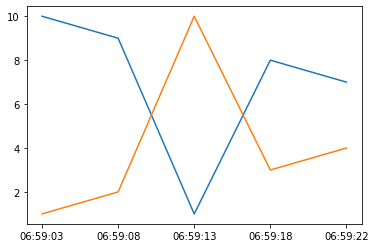

In [40]:
y = [resultados [1][1][0][1], resultados [2][1][0][1], resultados [3][1][0][1], resultados [4][1][0][1], resultados [5][1][0][1]]
x = [resultados [1][0], resultados [2][0], resultados [3][0], resultados [4][0], resultados [5][0]]

w = [resultados [1][1][1][1], resultados [2][1][1][1], resultados [3][1][1][1], resultados [4][1][1][1], resultados [5][1][1][1]]


plt.plot(x,y)
plt.plot(x,w)

https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:04:00', []]


([<matplotlib.patches.Wedge at 0x7efe56bfaf10>,
 [Text(-0.45695648023571717, 1.000595210447554, 'Negativo'),
  Text(0.4569564802357173, -1.000595210447554, 'Positivo')])

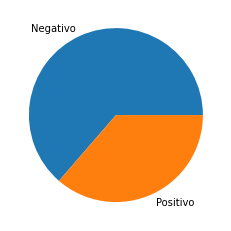

https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['trump', 'just', 'handed', 'more', 'disturbing', 'evidence', 'to', 'riot', 'committee', 'in', 'interview', 'with', 'abcs', 'karl', 'impeachment', 'attorney', 'httpstcohqcuhtdn5o'] 0
['mattgaetz', 'except', 'enable', 'the', 'biggest', 'enemy', 'to', 'our', 'democracy', 'in', 'the', 'last', '40', 'yearstrump'] 0
['rt', 'annmlipton', 'fancy', 'that'] 0
['rt', 'sheminfinite', 'also', 'they', 'forgot', 'to', 'acknowledge', 'that', 'president', 'trump', 'was', 'right', 'the', 'entire', 'time', 'about', 'it', 'being', 'a', 'complete', 'witch', 'hunt', 'and…'] 0
['rt', 'steveschmidtses', 'senator', 'i', 'don’t', 'hate', 'anyone', '', 'i', 'do', 'have', 'a', 'seething', 'contempt', 'for', 'you', 'and', 'your', 'colleagues', 'who', 'have', 'been', 'silent', 'enablers…'] 0
['rt', 'majesticbeauty5', 'chile', 'what', 'the', 'fuck', 'is', 'this', 'i', 'dont', 'know', 'whether', 'to', 'laugh', 'or', 'to', 'cry', 'httpst

['07:04:07', [('0', 11)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'mmpadellan', 'im', 'old', 'enough', 'to', 'remember', 'when', 'republicans', 'gave', 'trump', 'all', 'of', 'the', 'credit', 'for', 'the', 'stock', 'market', 'when', 'it', 'was', 'only', 'at', '30000…'] 0
['gop', 'thinks', 'we', 'forgot', 'we', 'havent\n\nall', 'rinos', 'out'] 0
['rt', 'johnfugelsang', 'trump', 'is', 'jesus', 'for', 'followers', 'of', 'jesus', 'who', 'reject', 'the', 'actual', 'teachings', 'of', 'jesus'] 0
['rt', 'blisslightlove', 'the', 'one', 'universal', 'creator', 'is\n\nour', 'president\ndonald', 'j', 'trump🇺🇸\n\nour', 'father🙌🙌🙌', 'httpstcoek2gqkgnbi'] 0
['rt', 'joncoopertweets', 'newsmax', 'and', 'oan', 'have', 'been', 'sued', '—', 'potentially', 'for', 'billions', 'of', 'dollars', '—', 'for', 'spreading', 'false', 'conspiracy', 'theories', 'that', 'vo…'] 0
['rt', 'mkraju', 'breaking', 'federal', 'grand', 'jury', 'has', 'returned', 'an', 'indictment', 'against', 'former', 'tr

['07:04:11', [('0', 11)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['brunothegreat32', 'henndawg1', 'mvee207', 'townhallcom', 'laurenboebert', 'i', 'didn’t', 'say', 'anything', 'about', 'any', 'other', 'president…', 'httpstco5tpdb4llnv'] 1
['rt', 'allinwithchris', 'new', 'former', 'trump', 'adviser', 'steve', 'bannon', 'indicted', 'by', 'federal', 'grand', 'jury', 'for', 'contempt', 'of', 'congress', 'httpstco1mvhipa6dh'] 1
['rt', 'joncoopertweets', 'boom', 'nyc', 'is', 'pursuing', 'its', 'plans', 'to', 'evict', 'trump', 'from', 'his', 'nyc', 'golf', 'course', 'calltoactivism\n\nnyc', 'will', 'defend', 'its', 'contra…'] 0
['rt', 'reportsdanews', 'this', 'whole', 'trial', 'is', 'a', 'sham\n\nhe’s', 'getting', 'off'] 0
['rt', 'anacabrera', 'breaking', 'federal', 'grand', 'jury', 'has', 'indicted', 'former', 'trump', 'adviser', 'steve', 'bannon', 'httpstco9cfpqqzutc'] 0
['rt', 'tedlieu', 'no', 'one', 'should', 'be', 'above', 'the', 'law', 'not', 'the', 'former', 'president',

['07:04:16', [('1', 3), ('0', 8)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['i', 'dont', 'see', 'bannon', 'fleeing', 'i', 'mean', 'its', 'a', 'possibility', 'but', 'not', 'a', 'high', 'one', '\n\nbecause', 'while', 'hes', 'been', 'indicted', 'he…', 'httpstconwh1eke65x'] 0
['rt', 'jobobtaeleifi', 'rep', 'adam', 'schiff', 'defends', 'his', 'role', 'in', 'the', 'russian', 'collusion', 'hoax', 'schiff', 'spent', 'the', 'last', '4', 'years', 'pushing', 'the', 'story', 'that', 'th…'] 0
['conexão', 'bolsonarotrump', 'ameaça', 'eleições', 'no', 'brasil\nhttpstcodyraqv9qzb'] 0
['rt', 'anacabrera', 'breaking', 'federal', 'grand', 'jury', 'has', 'indicted', 'former', 'trump', 'adviser', 'steve', 'bannon', 'httpstco9cfpqqzutc'] 0
['emails', 'reveal', 'new', 'details', 'of', 'trump', 'white', 'house', 'interference', 'in', 'cdc', 'covid', 'planning', '', 'politico', 'httpstco79ni8dcher'] 1
['rt', 'steveschmidtses', 'people', 'you', 'have', 'failed', 'to', 'stand', 'up', 'as', 'peaceful', 'pro

['07:04:21', [('0', 10), ('1', 1)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['bennie', 'thompson', 'you', 'are', 'doing', 'your', 'job', '', '', 'merrick', 'garland', 'isn’t', 'doing', 'his', 'job', '', '', 'i', 'say', 'out', 'merrick', 'garland…', 'httpstcoqztepmy8nd'] 1
['rt', 'caslernoel', 'if', 'you’re', 'shocked', 'that', 'trump', 'defended', 'folks', 'wanting', 'to', 'hang', 'pence', 'you', 'haven’t', 'been', 'paying', 'attention', 'mike', 'was', 'his', 'most', 'loya…'] 0
['rt', 'sethabramson', '🔒', 'icymi', 'if', 'you', 'know', 'who', 'steve', 'bannons', 'lawyer', 'is', 'you', 'understand', 'how', 'closely', 'trump', 'is', 'linked', 'to', 'the', 'coverup', 'of', 'his', 'o…'] 0
['rt', 'calltoactivism', 'just', 'this', '—', 'congressman', 'bennie', 'thompson', 'who', 'chairs', 'the', 'january', '6', 'committee', 'is', 'still', 'considering', 'bringing', 'trump', 'befor…'] 0
['rt', 'natashabertrand', 'breaking', 'on', 'cnn', 'trump', 'adviser', 'steve', 'bannon', 'has', 'been'

['07:04:26', [('1', 1), ('0', 10)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'davidcorndc', 'uh', 'when', 'was', 'the', 'last', 'time', 'congress', 'had', 'to', 'investigate', 'a', 'former', 'president', 'and', 'his', 'henchmen', 'for', 'an', 'insurrectionist', 'attack', 'o…'] 0
['rt', 'cnnpolitics', 'whats', 'next', 'in', 'former', 'president', 'donald', 'trumps', 'scramble', 'to', 'stop', 'the', 'house', 'from', 'getting', 'his', 'white', 'house', 'documents', 'httpst…'] 0
['rt', 'charliekirk11', 'if', 'tony', 'evers', 'had', 'accepted', 'trumps', 'offer', 'to', 'send', 'in', 'the', 'national', 'guard', 'during', 'last', 'summers', 'riots', 'there', 'would', 'not', 'be', 'a…'] 0
['trump', 'adviser', 'steve', 'bannon', 'indicted', 'for', 'contempt', 'of', 'congress', 'doj\n\nso', 'what', 'they', 'have', 'no', 'police', 'powers', '', 'read', 'consti…', 'httpstcozfhywkve62'] 1
['rt', 'ryanjreilly', 'a', 'defense', 'department', 'contractor', 'with', 'a', 'secret', 'security',

['07:04:31', [('0', 8), ('1', 3)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:04:35', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:04:40', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:04:45', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:04:50', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:04:55', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:05:00', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'adamkinzinger', 'normally', 'huge', 'news', '', 'today', 'we', 'call', 'this', '“friday”\n\ntrump', 'dismisses', 'rioters', 'calls', 'to', 'hang', 'pence', 'people', 'were', 'very', 'angry…'] 1
['trump', 'openly', 'defends', 'insurrectionists', 'trying', 'to', 'hang', 'pence', 'as', '‘common', 'sense’', 'httpstcowjeobamnaw', 'via', 'intelligencer'] 0
['rt', 'theturtlewoman1', 'johnpavlovitz', 'you', 'just', 'have', 'to', 'understand', 'that', 'rules', 'and', 'laws', 'don’t', 'apply', 'to', 'the', 'rich', 'and', 'now', 'thanks', 'to', 'trump', 'politic…'] 1
['rt', 'steveschmidtses', 'you', 'are', 'extremely', 'dishonest', 'more', 'than', '80', 'percent', 'of', 'monies', 'raised', 'by', 'the', 'lincoln', 'project', 'went', 'to', 'spending', 'on', 'voter', 'co…'] 0
['a', 'trump', 'appointed', 'judge', 'has', 'been', 'assigned', 'to', 'hear', 'bannons', 'case', 'so', 'dont', 'get', 'your', 'hopes', 'up

['07:05:06', [('1', 5), ('0', 6)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'lacadri34', 'elections', 'have', 'consequences'] 0==>       (7 + 1) / 8]
['rt', 'adamparkhomenko', 'i’m', 'glad', 'trump', 'keeps', 'admitting', 'that', 'the', 'jan', '6', 'terrorists', 'were', 'his', 'people', 'and', 'not', 'antifa', 'or', 'fbi', 'agents'] 1
['rt', 'votejohngibbs', 'thank', 'you', 'cortessteve', 'for', 'the', 'support', 'and', 'for', 'being', 'a', 'great', 'fighter', 'for', 'our', 'country', 'i', 'hope', 'to', 'do', 'the', 'same', 'in', 'congress'] 1
['7', 'it’s', 'clear', 'that', 'when', 'it', 'comes', 'to', 'rebuilding', 'our', 'country', 'democrats', 'are', 'ready', 'to', 'roll', 'up', 'their', 'sleeves', 'and', 'delive…', 'httpstcookm2bmzx2m'] 1
['rt', 'jusplaintalk101', 'thejusticedept', 'ag', 'garland', 'i', 'want', 'to', 'believe', 'this', 'with', 'all', 'my', 'heart', 'trump', 'should', 'be', 'at', 'the', 'top', 'of', 'your', 'investigations…'] 0
['rt', 'harrisonjaime', 'y

['07:05:11', [('0', 6), ('1', 5)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'stephenking', 'trump', 'is', 'never', 'going', 'to', 'jail', 'he', 'deserves', 'to', 'but', 'he’s', 'rich', 'and', 'powerful', 'instead', 'of', 'poor', 'and', 'black', 'welcome', 'to', 'america'] 0
['blahbla08277980', 'mappingfl', 'imo', 'it', 'doesnt', 'seem', 'fair', 'to', 'me', 'that', 'a', 'trump', '16', 'state', 'has', 'one', 'of', '2', 'districts', 'being', 'like…', 'httpstcohrdytokvfj'] 0
['whats', 'up', 'with', 'these', 'judges', 'youre', 'supposed', 'to', 'have', 'your', 'phone', 'turned', 'off', 'during', 'a', 'trial', 'trumps', 'rallying', 'tone…', 'httpstcoqpi9ut3qhq'] 0
['rt', 'laurie0801', 'jimjordan', 'and', 'how', 'about', 'those', 'phone', 'calls', 'on', 'january', '6th', 'with', 'trump', 'what', 'do', 'you', 'have', 'to', 'say', 'about', 'that', 'httpstcoyet…'] 0
['rt', 'jannwolfe', 'rep', 'liz', 'cheney', 'just', 'now\n\n“mr', 'trump’s', 'privilege', 'arguments', 'do', 'however',

['07:05:16', [('0', 10), ('1', 1)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['myth', 'the', 'trump', '', 'russia', 'dossier', 'is', 'becoming', 'more', 'true', 'with', 'time\n\ntruth', 'the', 'washington', 'post', 'just', 'took', 'the', 'unu…', 'httpstcol8wnvj8txm'] 1
['rt', 'calltoactivism', 'who', 'else', 'wants', 'trump', 'to', 'testify', 'under', 'oath', 'for', '11', 'hours', 'on', 'live', 'television', 'and', 'explain', 'why', 'the', 'national', 'guard', 'wasn’t', 'de…'] 0
['rt', 'emptywheel', 'heres', 'a', 'list', 'of', 'trump', 'pardons', '\n\nhttpstco0n0j463crn\n\nin', 'addition', 'to', 'bannon', 'flynn', 'papadopoulos', 'and', 'stone', 'bernie', 'ke…'] 0
['rt', 'travisbhill5', 'bro', 'what', 'is', 'the', 'onion', 'even', 'supposed', 'to', 'do', 'at', 'this', 'point'] 0
['rt', 'joncoopertweets', 'boom', 'nyc', 'is', 'pursuing', 'its', 'plans', 'to', 'evict', 'trump', 'from', 'his', 'nyc', 'golf', 'course', 'calltoactivism\n\nnyc', 'will', 'defend', 'its', 'contra…'] 0
['rt

['07:05:21', [('1', 3), ('0', 8)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['what'] 0:=================================================>       (7 + 1) / 8]
['rt', 'alpine106', 'trumps', 'chief', 'of', 'staff', 'mark', 'meadows', 'now', 'faces', 'criminal', 'contempt', 'of', 'congress', 'charges', 'for', '', 'httpstcocomvtg0vlj', 'via', 'mai…'] 1
['rt', 'cernovich', 'trump', 'is', 'a', 'fucking', 'boomer', 'who', 'still', 'talked', 'to', 'press', 'and', 'let', 'bad', 'coverage', 'bother', 'him', 'trump', 'just', 'gave', 'jon', 'karl', 'a', '90', 'minute', 'p…'] 0
['rt', 'davetroy', 'worst', 'news', 'all', 'day'] 0
['former', 'trump', 'adviser', 'steve', 'bannon', 'indicted', 'by', 'federal', 'grand', 'jury', 'for', 'contempt', 'of', 'congress', 'httpstcoy5d3iguka6', 'via', 'yahoonews'] 0
['rt', 'projectlincoln', 'donald', 'trump', 'is', 'a', 'talker', '\n\njoe', 'biden', 'is', 'a', 'builder', 'httpstcobjmltogv98'] 0
['the', 'trump', 'years', 'were', 'sooooo', 'draining', 'that', '

['07:05:26', [('0', 7), ('1', 4)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'elisestefanik', 'for', 'years', 'democrats', 'baselessly', 'accused', 'president', 'trump', 'of', 'weaponizing', 'the', 'doj', '\n\nin', 'reality', 'it', 'is', 'the', 'left', 'that', 'has…'] 0
['since', 'joe', 'biden', 'shut', 'down', 'fed', 'oil', 'productionhigher', 'prices', 'if', 'joe', 'looked', 'food', 'is', 'delivered', 'by', 'truck', 'to', 'all', 'food', 'ma…', 'httpstcobdf9capdfk'] 0
['rt', 'sethabramson', 'given', 'that', 'the', 'first', 'time', 'steve', 'bannon', 'was', 'indicted', 'during', 'the', 'trump', 'presidency', 'he', 'was', 'found', 'on', 'the', 'yacht', 'of', 'a', 'chinese…'] 0
['rt', 'ap', 'breaking', 'exdonald', 'trump', 'aide', 'steve', 'bannon', 'has', 'been', 'indicted', 'on', 'contempt', 'of', 'congress', 'charges', 'after', 'defying', 'jan', '6', 'committee', 'subpoe…'] 0
['rt', 'foursticksnate', 'ive', 'never', 'seen', 'these', 'perverted', 'amp', 'racist', 'videos\n\n

['07:05:31', [('0', 10), ('1', 1)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:05:35', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:05:40', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:05:45', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:05:50', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:05:55', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:06:00', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['jennaellisesq', 'she', 'is', 'a', 'good', 'republican', 'when', 'she', 'voted', 'with', 'trump', 'but', 'ba', 'when', 'she', 'followed', 'the', 'evidence', 'see', 'a', 'problem', 'with', 'that'] 1
['rt', 'stevenbeschloss', 'may', 'this', 'be', 'a', 'message', 'to', 'every', 'other', 'arrogant', 'trumpfueled', 'subpoena', 'defiers'] 0
['trump', 'scores', 'two', 'legal', 'wins', 'after', 'summer', 'zervos', 'drops', 'lawsuit', 'and', 'michael', 'cohens', 'suit', 'against', 'trump', 'org', 'dismissed\n\nhttpstcop7ihmvlagu'] 0
['rt', 'opinionesdel', 'también', 'caerás', '\n\nlos', 'hijos', 'de', 'uribe', 'son', 'como', 'los', 'de', 'trump', 'muy', 'corruptos', 'y', 'protegidos', 'por', 'el', 'papá', '…', 'httpstcojzzexh…'] 0
['former', 'top', 'trump', 'adviser', 'steve', 'bannon', 'criminally', 'charged', 'httpstcoo5btvqahjm'] 0
['rt', 'stephenking', 'trump', 'is', 'never', 'going', 'to', 'jail', 'he', 'dese

['07:06:06', [('1', 2), ('0', 9)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'jobobtaeleifi', 'rep', 'adam', 'schiff', 'defends', 'his', 'role', 'in', 'the', 'russian', 'collusion', 'hoax', 'schiff', 'spent', 'the', 'last', '4', 'years', 'pushing', 'the', 'story', 'that', 'th…'] 0
['rt', 'politibunny', 'i', 'hope', 'desantis', 'knows', 'what', 'a', 'massive', 'mistake', 'this', 'would', 'be', '', '\n\ndesantis', 'should', 'run'] 0
['rt', 'cruellaisdevine', 'senwhitehouse', 'important', '\n\nnancy', 'maclean', 'duke', 'u', 'professor', 'amp', 'historian', 'talks', 'about', 'the', 'gops', 'long', 'game', 'as', 'progress…'] 0
['lawsuit', 'and', 'my', 'woman', 'got', 'hurt', 'jlo', 'mary', 'j', 'blige', 'house', 'speaker', 'nancy', 'pelosi', 'asap', 'donald', 'j', 'trump', 'asap', '￼', 'and', 'make', 'sur…', 'httpstcoh08lvpbza5'] 0
['bannons', 'case', 'has', 'been', 'assigned', 'to', 'a', 'trump', 'appointed', 'judge'] 0
['rt', 'wolfblitzer', 'us', 'attorney', 'for', 'dc', 'matt

['07:06:11', [('0', 10), ('1', 1)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'clairecmc', 'remember', 'that', 'trump', 'shut', 'down', 'executive', 'privilege', 'when', 'it', 'came', 'to', 'the', 'obama', 'presidency', 'biden', 'is', 'only', 'doing', 'exactly', 'what', 'tru…'] 0
['clearly', 'the', 'two', 'federal', 'grand', 'jury', 'charges', 'of', 'contempt', 'of', 'congress', 'filed', 'against', 'steve', 'bannon', 'send', 'a', 'powerful', 'mess…', 'httpstcov0trdci11t'] 0
['rt', 'kylegriffin1', 'the', 'white', 'house', 'mocked', 'trump', 'after', 'he', 'said', 'he', 'was', 'sending', 'his', 'envoy', 'ambassador', 'to', 'kosovo\n\noutside', 'of', 'his', 'very', 'active…'] 0
['rt', 'woodruffbets', 'bannons', 'case', 'is', 'assigned', 'to', 'judge', 'carl', 'j', 'nichols', 'a', 'trump', 'appointee', 'he', 'clerked', 'for', 'clarence', 'thomas', '\n\nhttpstcok7f6…'] 0
['teampelosi', 'weird', 'im', 'pretty', 'sure', 'trump', 'actually', 'did', 'that', 'what', 'the', 'democrats',

['07:06:16', [('0', 8), ('1', 3)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['b52malmet', 'slow', 'and', 'steady', 'when', 'it', 'comes', 'to', 'trump', 'and', 'treason', 'he', 'must', 'be', 'infallible'] 0
['ericmmatheny', 'cnn', 'has', 'to', 'make', 'everything', 'about', 'race…and', 'trump', 'how’d', 'they', 'get', 'their', 'views'] 0
['rt', 'sethn12', 'yes', 'it', 'is', '‘common', 'sense’', 'to', 'support', 'public', 'hanging', 'of', 'your', 'coworker', '\n', 'if', 'you’re', 'a', 'psychopath', '', 'httpstcos3ub0ydqt9'] 1
['better', 'not', 'let', 'david', 'baddiel', 'see', 'this', 'bloke', '😬🤡😬', 'guiltyaschargred'] 0
['rt', 'covidoversight', 'today', 'whipclyburn', 'is', 'demanding', 'answers', 'from', 'former', 'cdc', 'dir', 'robert', 'r', 'redfield', 'after', 'new', 'evidence', 'sheds', 'light', 'on', 'repe…'] 0
['rt', 'keitholbermann', 'the', 'way', 'conservative', 'whores', 'like', 'this', 'fascist', 'twist', 'reality', 'english', 'and', 'insanity', 'to', 'defend', 'their'

['07:06:21', [('0', 8), ('1', 3)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'natashabertrand', 'breaking', 'on', 'cnn', 'trump', 'adviser', 'steve', 'bannon', 'has', 'been', 'indicted', 'by', 'a', 'federal', 'grand', 'jury'] 0
['imspeaking13', 'good', 'news', '', 'i', 'just', 'noticed', 'bannons', 'warroom', 'broadcast', 'narrowcast', 'boasting', '', 'that', 'were', 'taking', 'ov…', 'httpstcosj1co9qqul'] 1
['rt', 'ericgarland', 'guys\n\nim', 'starting', 'to', 'think', 'trump', 'wont', 'be', 'reinstalled', 'as', 'president', '😂🖕🤣'] 0
['rt', 'palmerreport', 'merrick', 'garland’s', 'doj', 'has', 'criminally', 'indicted', 'steve', 'bannon', 'for', 'contempt', 'bannon', 'is', 'surrendering', 'this', 'was', 'always', 'going', 'to…'] 0
['rt', 'mybigredtruck', 'and', 'pence', 'trending', 'now\nregarding', 'the', 'chants', 'to', 'hang', 'pence', 'trump', 'justified', 'it', 'by', 'saying', 'well', 'the', 'people', 'were', 'very', 'a…'] 0
['httpstcogxkkabejvc', 'lv11', 'trumpdonating'

['07:06:26', [('0', 8), ('1', 3)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['what', 'a', 'fucking', 'moron'] 0=========================>       (7 + 1) / 8]
['mattgaetz', 'i', 'know', 'he', 'was', 'born', 'a', 'degenerate', 'pretty', 'much', 'sums', 'up', 'trump', 'and', 'company'] 0
['rt', 'travisbhill5', 'bro', 'what', 'is', 'the', 'onion', 'even', 'supposed', 'to', 'do', 'at', 'this', 'point'] 0
['rt', 'joncoopertweets', 'boom', 'nyc', 'is', 'pursuing', 'its', 'plans', 'to', 'evict', 'trump', 'from', 'his', 'nyc', 'golf', 'course', 'calltoactivism\n\nnyc', 'will', 'defend', 'its', 'contra…'] 0
['rt', 'robertmackey', 'a', 'defense', 'witness', 'told', 'the', 'jury', 'the', 'men', 'kyle', 'rittenhouse', 'killed', 'were', 'rioters', 'the', 'trial', 'judge', 'stopped', 'the', 'prosecutor', 'fr…'] 0
['rt', 'thedailybeast', 'donald', 'trump', 'has', 'a', 'long', 'track', 'record', 'of', 'defending', 'the', 'indefensible—but', 'this', 'is', 'something', 'else', 'httpstcogmqwzhx5gk'] 0

['07:06:31', [('0', 11)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:06:35', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:06:40', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:06:45', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:06:50', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:06:55', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:07:00', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'jimsciutto', 'this', 'audio', 'of', 'the', 'former', 'president', 'of', 'the', 'united', 'states', 'regarding', 'the', 'former', 'vice', 'president', 'is', 'a', 'mustlisten', 'httpstco…'] 0
['rt', 'calltoactivism', 'just', 'this', '—', 'congressman', 'bennie', 'thompson', 'who', 'chairs', 'the', 'january', '6', 'committee', 'is', 'still', 'considering', 'bringing', 'trump', 'befor…'] 0
['rt', 'gtconway3d', 'tfg', 'deleted', 'this', 'tweet', 'but', 'it', 'was', 'precisely', 'the', 'same', 'sentiment', 'httpstcowvysjhbi02'] 0
['rt', 'charliekirk11', 'if', 'tony', 'evers', 'had', 'accepted', 'trumps', 'offer', 'to', 'send', 'in', 'the', 'national', 'guard', 'during', 'last', 'summers', 'riots', 'there', 'would', 'not', 'be', 'a…'] 0
['rt', 'ericgarland', 'guys\n\nim', 'starting', 'to', 'think', 'trump', 'wont', 'be', 'reinstalled', 'as', 'president', '😂🖕🤣'] 0
['how', 'stupid', 'are', 'these', 'people\

['07:07:06', [('0', 9), ('1', 2)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'spenolpalinusa', 'mr', 'trump', 'whom', 'i', 'dactually', 'did', 'support', 'httpstco9u3aqwz1ln'] 0
['documents', 'reveal', 'new', 'details', 'of', 'trump', 'political', 'interference', 'in', 'covid', 'response', 'httpstco3knmobpyvw', 'httpstcosmjutwsaik'] 1
['rt', 'silveradie', '⚖️\n\nsteve', 'bannon', '', '👉defied', 'congress', 'and', 'has', 'been', 'indicted', '\n\nconcealed—information', 'on', 'the', '', 'coup', 'trumpincited\n\nhis', 'indictm…'] 1
['rt', 'cortessteve', 'a', 'new', 'rising', 'star', 'of', 'the', 'america', 'first', 'movement', 'john', 'gibbs', 'announces', 'his', 'candidacy', 'to', 'replace', 'trumpimpeacher', 'rep', 'pete', 'm…'] 1
['rt', 'steveschmidtses', 'you', 'are', 'extremely', 'dishonest', 'more', 'than', '80', 'percent', 'of', 'monies', 'raised', 'by', 'the', 'lincoln', 'project', 'went', 'to', 'spending', 'on', 'voter', 'co…'] 0
['rt', 'jukehorse50', 'ok', 'bannon', '

['07:07:11', [('0', 7), ('1', 4)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['yes', 'httpstcopw814d15qh'] 0=============================>       (7 + 1) / 8]
['rt', 'sethabramson', '🔒', 'icymi', 'if', 'you', 'know', 'who', 'steve', 'bannons', 'lawyer', 'is', 'you', 'understand', 'how', 'closely', 'trump', 'is', 'linked', 'to', 'the', 'coverup', 'of', 'his', 'o…'] 0
['rt', 'tedlieu', 'no', 'one', 'should', 'be', 'above', 'the', 'law', 'not', 'the', 'former', 'president', 'not', 'his', 'staff', 'not', 'members', 'of', 'congress', 'and', 'not', 'steve', 'bannon'] 0
['rt', 'ryanjreilly', 'a', 'defense', 'department', 'contractor', 'with', 'a', 'secret', 'security', 'clearance', 'charged', 'in', 'connection', 'with', 'jan', '6', 'used', 'his', 'work', 'computer…'] 0
['rt', 'natashabertrand', 'breaking', 'on', 'cnn', 'trump', 'adviser', 'steve', 'bannon', 'has', 'been', 'indicted', 'by', 'a', 'federal', 'grand', 'jury'] 0
['jayseos3', 'scoontv', 'brilliantcode', 'for', '', '', 'anyone', 

['07:07:16', [('0', 8), ('1', 3)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'oxxrowanxxo', 'breaking', 'trumps', 'adviser', 'steve', 'bannon', 'has', 'been', 'indicted', 'by', 'federal', 'grand', 'jury', 'on', '2', 'counts', 'for', 'failure', 'to', 'comply', 'with', 'subp…'] 0
['rt', 'gem56336989', '“murkowski', 'has', 'got', 'to', 'go”\xa0', 'president', 'trump', '', 'httpstco7qppa3zpvo'] 0
['its', 'about', 'damn', 'time', '', 'this', 'shouldnt', 'have', 'been', 'complicated', 'and', 'take', 'weeks', 'to', 'go', 'through', '', 'he', 'ignored', 'a', 'subpoena', 'h…', 'httpstcooklmkcgdqa'] 0
['rt', 'cernovich', 'trump', 'is', 'a', 'fucking', 'boomer', 'who', 'still', 'talked', 'to', 'press', 'and', 'let', 'bad', 'coverage', 'bother', 'him', 'trump', 'just', 'gave', 'jon', 'karl', 'a', '90', 'minute', 'p…'] 0
['rt', 'themarketswork', 'remember', 'heading', 'into', '2017', 'when', 'republicans', 'controlled', 'the', 'senate', 'the', 'house', 'the', 'presidency', '33', 'governo

['07:07:22', [('0', 10), ('1', 1)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'tribelaw', 'doj', 'is', 'rightly', 'saying', 'executive', 'privilege', 'belongs', 'not', 'to', 'any', 'individual', 'but', 'to', 'the', 'executive', 'branch', 'of', 'which', 'the', 'one', 'and', 'onl…'] 0
['rt', 'trollmoti', 'stephenking', 'not', 'sure', '…', 'with', 'the', 'kind', 'of', 'popularity', '\n\namerica', 'first', '…', 'courtesy', 'president', 'trump', '😜\n\n', 'httpstcokyqhrry2b2'] 1
['rt', 'sethabramson', '🔒', 'could', 'there', 'be', 'a', 'better', 'day', 'to', 'republish', 'this', 'list', 'of', 'misconduct', 'by', 'trump', 'aides', 'allies', 'advisers', 'agents', 'attorney…'] 0
['rt', 'realchasegeiser', 'no', 'matter', 'how', 'many', 'times', 'the', 'democrats', 'say', 'it', 'donald', 'trump', 'never', 'once', 'used', 'language', 'to', 'incite', 'violence\n\nhe', 'was', 'banne…'] 0
['rt', 'marshablackburn', 'hunter', 'biden', 'was', 'never', 'investigated', 'because', 'the', 'fbi', 'w

['07:07:26', [('0', 9), ('1', 2)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'levparnas', 'finally', '👇', '💥'] 0================>       (7 + 1) / 8]
['rt', 'zaleskiluke', 'kaitlancollins', 'schneidercnn', 'if', 'you', 'can’t', 'arrest', 'steve', 'bannon', 'you', 'can’t', 'arrest', 'anyone', 'trump’s', 'not', 'guilty', 'he’s', 'guilty', 't…'] 0
['i', 'mean', 'maybe', 'the', 'real', 'crime', 'here', 'is', 'your', 'egregious', 'comma', 'splice', 'in', 'that', 'last', 'sentence'] 0
['rt', 'therickwilson', 'at', 'least', 'bannon', 'can', 'count', 'on', 'trump', 'to', 'pardon', 'him', 'for\n\nohwait'] 0
['macfarlanenews', 'trump', 'will', 'declare', 'maralago', 'a', 'soverign', 'nation', 'with', 'no', 'extradition', 'to', 'the', 'us', 'by', 'monday', 'and', 'bannon', 'will', 'be', 'in', 'residence'] 1
['cool', 'i', 'love', 'that', 'he’s', 'going', 'to', 'have', 'to', 'turn', 'himself', 'in', 'but', 'i', 'have', 'plenty', 'of', 'wet', 'blanket', 'expectations', 'left'] 1
['rt', 're

['07:07:31', [('0', 8), ('1', 3)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:07:35', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:07:40', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:07:45', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:07:50', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:07:55', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:08:00', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['stevehiltonx', 'trump', 'should', 'sue', 'the', 'media', 'that', 'constantly', 'smeared', 'him', 'plus', 'he', 'should', 'sue', 'adam', 'schiff'] 0
['trump', 'girl', '🇺🇲🦅🇺🇲', 'i', 'follow', 'back', 'all', 'patriots', 'is', 'now', 'following', 'me', 'on', 'twitter', 'httpstcorakhzmykxy'] 1
['rt', 'tribelaw', 'doj', 'is', 'rightly', 'saying', 'executive', 'privilege', 'belongs', 'not', 'to', 'any', 'individual', 'but', 'to', 'the', 'executive', 'branch', 'of', 'which', 'the', 'one', 'and', 'onl…'] 0
['bluntlyangry', 'trump', 'never', 'got', 'above', '50', 'except', 'for', 'rasmussen', 'a', 'completely', 'skewed', 'polling', 'you', 'cant', 'count', 'online', 'po…', 'httpstcoubeg2vffje'] 0
['gasecofstate', 'pittcyber', 'never', 'forget', 'january', '6th', 'there', 'is', 'no', 'question', 'none', 'that', 'president', 'trump', 'is', 'practically…', 'httpstcoavvg1afgss'] 0
['rt', 'travisbhill5', 'bro', 'what', 

['07:08:06', [('0', 10), ('1', 1)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'tribelaw', 'doj', 'is', 'rightly', 'saying', 'executive', 'privilege', 'belongs', 'not', 'to', 'any', 'individual', 'but', 'to', 'the', 'executive', 'branch', 'of', 'which', 'the', 'one', 'and', 'onl…'] 0
['rt', 'donwinslow', 'please', 'understand', 'that', 'steve', 'bannons', 'indictment', 'only', 'begins', 'a', 'legal', 'process\n\neven', 'when', 'arrested', 'he', 'will', 'likely', 'be', 'immedia…'] 0
['rt', 'donwinslow', 'only', 'in', 'trumps', 'part', 'of', 'america', 'could', 'a', 'person', 'suit', 'up', 'with', 'an', 'ar', '15', 'lie', 'on', 'camera', 'about', 'being', 'an', 'emt', 'lie', 'on', 'camera', 'multi…'] 0
['repadamschiff', 'oh', 'you', 'got', 'him', 'for', 'sure', 'this', 'time', '🤣🤣', 'just', 'like', 'roger', 'stone', 'russian', 'hoax', 'ukraine', 'and', 'you', 'always', 'en…', 'httpstcoc0f6bhv1in'] 0
['jackposobiec', 'weaponizing', 'the', 'doj', 'didnt', 'we', 'hear', 'a', 'certa

['07:08:11', [('0', 11)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'caslernoel', 'the', 'fact', 'that', 'harold', 'bornstein', 'was', 'trump’s', 'physician', 'dr', 'feelgood', 'since', 'the', '80’s', 'had', 'been', 'sued', 'for', 'overprescribing', 'had', 'h…'] 0
['rt', 'therickwilson', 'at', 'least', 'bannon', 'can', 'count', 'on', 'trump', 'to', 'pardon', 'him', 'for\n\nohwait'] 0
['rt', 'leandroruschel', 'volto', 'a', 'afirmar', 'esse', 'é', 'o', 'maior', 'escândalo', 'político', 'da', 'história', 'americana', 'deep', 'state', 'em', 'conluio', 'com', 'o', 'partido', 'democrat…'] 0
['well', 'now', '⬇️'] 0
['adeptstack', 'super7664', 'goebiwonkinobie', '53mattyice', 'reutersfacts', 'oh', 'wow', 'thanks', 'reuter', 'i’m', 'glad', 'they', 'put', 'context', 'i…', 'httpstco0zqjeefk76'] 1
['rt', 'huffpostpol', 'the', 'president', 'was', 'totally', 'fine', 'with', 'a', 'mob', 'wanting', 'to', 'kill', 'his', 'vice', 'president', 'according', 'to', 'a', 'newly', 'released

['07:08:16', [('0', 7), ('1', 4)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['cant', 'say', 'it', 'anymore', 'clearer', 'or', 'louder'] 0       (7 + 1) / 8]
['rt', 'crikeynews', 'the', 'claim', 'that', 'hillsong', 'figure', 'brian', 'houston', 'was', 'invited', 'to', 'the', 'trump', 'white', 'house', 'by', 'scott', 'morrison', 'and', 'was', 'rejected', 'was', 'd…'] 0
['bendoverlib', 'tanya07836673', 'berniceking', '😆\n\nplease', 'stop', 'with', 'fox', 'oan', 'and', 'newsmax', '\nthe', 'irony', 'of', 'the', 'trump', 'won', 'cro…', 'httpstcosvlesqtdcb'] 0
['graysonmurray', 'f', 'trumpim', 'sure', 'he', 'cheated'] 0
['rt', 'limeylankey', 'stevehiltonx', 'theres', 'a', 'pattern', 'here', 'everything', 'the', 'democrats', 'project', 'on', 'trump', 'andor', 'the', 'republicans', 'is', 'in', 'fact', 'what', 't…'] 0
['seize', 'dynamic', 'eservices', 'with', 'domains', '\n💰', 'cats', 'trump', 'buy', 'domain', 'httpstcojvgysbtfah', 'httpstcoukiwnpufkw', 'httpstcom1zdg4wq1a'] 0
['when', 'bad

['07:08:22', [('0', 11)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['frisco', 'realtor', 'headed', 'to', 'prison', 'for', 'jan', '6', 'capitol', 'riot', 'sounds', 'off', 'on', 'viral', 'fame', 'trump', 'httpstcoxjcn0qbsat'] 0
['rt', 'sethabramson', '🔒', 'icymi', 'if', 'you', 'know', 'who', 'steve', 'bannons', 'lawyer', 'is', 'you', 'understand', 'how', 'closely', 'trump', 'is', 'linked', 'to', 'the', 'coverup', 'of', 'his', 'o…'] 0
['rt', 'oxxrowanxxo', 'i', 'remember', 'when', 'making', 'threats', 'to', 'a', 'government', 'official', 'meant', 'jail', 'time', 'now', 'people', 'can', 'build', 'gallows', 'at', 'the', 'capital', 'chan…'] 1
['rt', 'clairecmc', 'remember', 'that', 'trump', 'shut', 'down', 'executive', 'privilege', 'when', 'it', 'came', 'to', 'the', 'obama', 'presidency', 'biden', 'is', 'only', 'doing', 'exactly', 'what', 'tru…'] 0
['ap', 'and', 'politifact', 'can', 'kiss', 'my', 'conservative', 'bottom', '', 'donaldtrump', 'is', 'giant', 'and', 'mega', 'maga',

['07:08:26', [('0', 9), ('1', 2)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'sethabramson', 'given', 'that', 'the', 'first', 'time', 'steve', 'bannon', 'was', 'indicted', 'during', 'the', 'trump', 'presidency', 'he', 'was', 'found', 'on', 'the', 'yacht', 'of', 'a', 'chinese…'] 0
['rt', 'cnn', 'the', 'house', 'select', 'subcommittee', 'on', 'the', 'coronavirus', 'crisis', 'released', 'to', 'cnn', 'new', 'evidence', 'showing', 'how', 'cdc', 'officials', 'were', 'pressured', 'by', 't…'] 0
['open', 'smartnews', 'and', 'read', 'trump', 'just', 'handed', '‘more', 'disturbing', 'evidence’', 'to', 'riot', 'committee', 'in', 'interview', 'with', 'abc’s', 'kar…', 'httpstcozlrfisftjz'] 0
['rt', 'anacabrera', 'breaking', 'federal', 'grand', 'jury', 'has', 'indicted', 'former', 'trump', 'adviser', 'steve', 'bannon', 'httpstco9cfpqqzutc'] 0
['rt', 'huffpostpol', 'brad', 'rukstales', 'who', 'gave', '25000', 'to', 'trumps', 'campaign', 'and', 'gop', 'committees', 'in', '2020', 'said', 'he'

['07:08:31', [('0', 10), ('1', 1)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:08:35', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:08:40', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:08:45', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:08:50', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:08:55', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:09:00', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['as', 'someone', 'else', 'pointed', 'out\nok', 'he', 'clerked', 'for', 'clarence', 'thomas', '', 'whose', 'wife', 'helped', 'organise', 'buses', 'to', 'ship', 'peopl…', 'httpstcobomtror28t'] 0
['rt', 'darshunkendrick', 'good', 'morning', 'to', 'everyone', 'except', 'the', 'federal', 'judge', 'blocking', 'trumps', 'insurrection', 'calls', 'the', 'defendants', 'attorney', 'in', 'arb…'] 1
['rt', 'ramcnn', 'trump', 'scores', 'two', 'legal', 'wins', 'after', 'summer', 'zervos', 'drops', 'lawsuit', 'and', 'michael', 'cohens', 'suit', 'against', 'trump', 'org', 'dismissed\nhttpstc…'] 0
['ms', 'zervos', 'stands', 'by', 'the', 'allegations', 'in', 'her', 'complaint', 'and', 'has', 'accepted', 'no', 'compensation', 'zervos', 'attorneys', 'stated'] 0
['rt', 'deefonta', '👏👏👏👏👏👏🙌🤘🇺🇸', 'a', 'good', 'day', 'for', 'our', 'democracy', 'and', 'just', 'the', 'beginning', 'all', 'traitors', 'need', 'to', 'be', 'indicted', 'e

['07:09:05', [('0', 10), ('1', 1)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'aaronparnas', 'now', 'that', 'bannon', 'has', 'been', 'indicted', 'let', 'me', 'breakdown', 'what', 'this', 'means', 'for', 'him', 'and', 'other', 'trump', 'associates', 'as', 'well', 'as', 'next', 'st…'] 0
['steve', 'bannon', 'indicted', 'httpstcoba2zq6d11s'] 0
['rt', 'doomsdayscw', 'president', 'bannon', 'admits', 'trumps', 'cabinet', 'nominees', 'were', 'selected', 'to', 'destroy', 'their', 'agencies', 'httpstcovcwoit1zni'] 0
['washingtonadam7', 'madandmatt', 'jennaellisesq', 'labor', 'participation', 'rates', 'are', 'skewed', 'due', 'to', 'the', 'pandemic', 'as', 'is', 'gdp', 'grow…', 'httpstcozldv4fe0jo'] 0
['rt', 'ramcnn', 'trump', 'scores', 'two', 'legal', 'wins', 'after', 'summer', 'zervos', 'drops', 'lawsuit', 'and', 'michael', 'cohens', 'suit', 'against', 'trump', 'org', 'dismissed\nhttpstc…'] 0
['ctstormy', 'joycewhitevance', 'httpstcollc5mzuyjj'] 0
['rt', 'mehdirhasan', 'sorry', 'chris'

['07:09:11', [('0', 10), ('1', 1)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'palmerreport', 'merrick', 'garland’s', 'doj', 'has', 'criminally', 'indicted', 'steve', 'bannon', 'for', 'contempt', 'bannon', 'is', 'surrendering', 'this', 'was', 'always', 'going', 'to…'] 0
['jennietetreault', 'trinitymustache', 'thats', 'not', 'theory', 'thats', 'fact', 'just', 'like', 'the', 'fact', 'that', 'donald', 'trump', 'was', 'elected…', 'httpstcobhoke8w1yo'] 0
['cernovich', 'the', 'democrats', 'fear', 'trump', 'they', 'don’t', 'fear', 'the', 'next', 'generation', 'stop', 'embarrassing', 'yourself'] 0
['rt', 'mattgaetz', 'the', 'fbi', 'is', 'the', 'enforcement', 'arm', 'of', 'the', 'mainstream', 'media'] 0
['rt', 'davidnir', 'heres', 'a', 'good', 'test', 'of', 'whether', 'trump', 'can', 'still', 'exert', 'executive', 'privilege', 'he', 'should', 'pardon', 'steve', 'bannon', 'right', 'now', 'and', 'see', 'how…'] 0
['rt', 'cherijacobus', 'if', 'garland', 'isnt', 'prosecuting', 'trump', 'an

['07:09:16', [('0', 11)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'richardgrenell', 'and', 'a', 'biden', 'appointee', 'at', 'doj', 'is', 'pushing', 'this…did', 'you', 'tweet', 'about', 'the', 'biden', 'appointee\n\nand', 'why', 'do', 'you', 'keep', 'protectin…'] 0
['every', 'single', 'gop', 'member', 'of', 'congress', 'will', 'forever', 'be', 'stained', 'by', 'their', 'complacency', 'or', 'participation', 'in', 'domestic', 'terro…', 'httpstcoqet7npzlcp'] 0
['rt', 'stephenking', 'trump', 'is', 'never', 'going', 'to', 'jail', 'he', 'deserves', 'to', 'but', 'he’s', 'rich', 'and', 'powerful', 'instead', 'of', 'poor', 'and', 'black', 'welcome', 'to', 'america'] 0
['rt', 'repraskin', 'the', 'grand', 'jury', 'indictment', 'of', 'steve', 'bannon', 'shows', 'that', 'even', 'the', 'insurrectionist', 'allies', 'of', 'donald', 'trump', 'are', 'not', 'above', 'the', 'law', 'a…'] 0
['reaganbattalion', 'i', 'appreciate', 'the', 'sentiment', 'but', 'i', 'fail', 'to', 'see', 'how'

['07:09:21', [('0', 10), ('1', 1)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'sayitnspinit', 'president', 'trump', 'warned', 'you', 'what', 'would', 'happen', 'with', 'biden', 'as', 'president'] 0
['rt', 'tribelaw', 'exactly', 'your', 'turn', 'to', 'do', 'what’s', 'right', 'mr', 'attorney', 'general', '\n\nno', 'executive', 'privilege', 'excuses', 'further', 'delay'] 0
['at', 'last❗🗽👏🏾👏🏻👏🏽👏🏻👏🏾👏🏼\nnd', 'sd', 'tn', 'tx', 'ut', 'vt', 'va', 'wa', 'wv', 'wi', 'wy', 'pa', 'ga', 'or', 'fl', 'ky', 'ne', 'ny', 'nc', 'sc', 'nm', 'nj', 'ma…', 'httpstcooq8z9kvmqw'] 0
['butterfly5069', 'donaldjtrumpjr', 'this', 'story', 'is', 'so', 'wrong', 'trump', 'said', 'and', 'did', 'get', 'our', 'reserves', 'filled', 'to', 'be', 'used', 'in', 'di…', 'httpstcorvvmlwzyrs'] 0
['rt', 'sethn12', 'yes', 'it', 'is', '‘common', 'sense’', 'to', 'support', 'public', 'hanging', 'of', 'your', 'coworker', '\n', 'if', 'you’re', 'a', 'psychopath', '', 'httpstcos3ub0ydqt9'] 1
['rt', 'snowconenicoley', 'steveschmid

['07:09:25', [('0', 9), ('1', 2)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'cortessteve', 'a', 'new', 'rising', 'star', 'of', 'the', 'america', 'first', 'movement', 'john', 'gibbs', 'announces', 'his', 'candidacy', 'to', 'replace', 'trumpimpeacher', 'rep', 'pete', 'm…'] 1
['rt', 'kimpossiblefact', 'this', 'is', 'just', 'the', '2021', 'equivalent', 'of', 'him', 'petting', 'trump’s', 'hair'] 0
['how', 'is', 'it', 'that', 'bannons', 'running', 'his', 'tv', 'show', 'it', 'runs', '56', 'est', 'daily', 'at', 'this', 'very', 'moment', 'if', 'he', 'is', 'under', 'arrest', '', 'jus…', 'httpstco64yyqifxoa'] 1
['rt', 'travisbhill5', 'bro', 'what', 'is', 'the', 'onion', 'even', 'supposed', 'to', 'do', 'at', 'this', 'point'] 0
['rt', 'thereidout', 'breaking', 'former', 'trump', 'adviser', 'steve', 'bannon', 'indicted', 'by', 'federal', 'grand', 'jury', 'for', 'contempt', 'of', 'congress\n\nhttpstcojdfgjmk…'] 0
['rt', 'walshfreedom', 'don’t', 'mean', 'to', 'be', 'a', 'downer', 'on', 'th

['07:09:31', [('1', 3), ('0', 8)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:09:35', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:09:40', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:09:45', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:09:50', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:09:55', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:10:00', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['icymi\n\nsigh'] 0=========================================>       (7 + 1) / 8]
['the', 'us', 'department', 'of', 'labor', 'said', 'it', 'was', 'moving', 'to', 'eliminate', 'a', 'trumpera', 'program', 'that', 'allowed', 'businesses', 'and', 'trade…', 'httpstcoq1ajt5ff85'] 1
['trumpera', 'battles', 'continue', 'amid', 'state', 'by', 'state', 'assault', 'on', 'civil', 'rights', 'aclu', 'president', 'httpstcogiweiwkj7m'] 0
['rt', 'gigicmka', 'paiyslee', 'this', 'is', 'troubling', 'httpstcodisrjui9nj'] 0
['rt', 'repraskin', 'the', 'grand', 'jury', 'indictment', 'of', 'steve', 'bannon', 'shows', 'that', 'even', 'the', 'insurrectionist', 'allies', 'of', 'donald', 'trump', 'are', 'not', 'above', 'the', 'law', 'a…'] 0
['rt', 'joncoopertweets', 'if', 'you', 'think', 'merrick', 'garland', 'must', 'be', 'tougher', 'on', 'trump', 'and', 'finally', 'hold', 'him', 'accountable', 'retweet', 'this', 'and', 'follow', 'cal

['07:10:06', [('0', 8), ('1', 3)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['people', 'really', 'dont', 'understand', 'what', 'couldve', 'been', 'that', 'day', 'in', 'january', 'or', 'whats', 'in', 'store', 'for', 'us', 'in', 'the', 'future', 'i', 'c…', 'httpstcofneovarf3z'] 0
['dalexconnect', 'truetrumper', 'the', 'genius', 'of', 'trump', 'calling', 'him', 'sleepy', 'joe', 'is', 'that', 'we', 'all', 'think', 'more', 'like', 'creepy', 'joe'] 0
['rt', 'ericgarland', 'well', 'well', '', 'somebody', 'who', 'used', 'their', 'security', 'clearance', 'in', 'an', 'attempted', 'coup', 'détat', 'that', 'is', 'very', 'bad', '😠😈⚖️'] 0
['rt', 'kylegriffin1', 'rep', 'jim', 'clyburn', 'on', 'siriusxm', 'how', 'are', 'you', 'going', 'to', 'let', 'this', 'country', 'come', 'down', 'over', 'one', 'guy', 'trump', 'whos', 'mentally', 'challe…'] 0
['rt', 'judicialwatch', 'they', 'froze', 'the', 'doj', 'for', 'two', 'years', 'to', 'harass', 'trump', 'based', 'on', 'the', 'steele', 'dossier', 'lie', '

['07:10:12', [('0', 11)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'ericgarland', 'well', 'well', '', 'somebody', 'who', 'used', 'their', 'security', 'clearance', 'in', 'an', 'attempted', 'coup', 'détat', 'that', 'is', 'very', 'bad', '😠😈⚖️'] 0
['scottmgreer', 'this', 'is', 'unfair', 'that’s', 'what', 'every', 'politician', 'said', 'at', 'the', 'time', 'trump’s', 'statement', 'was', 'similar'] 1
['rt', 'politicussarah', 'why', 'must', 'our', 'media', 'be', 'like', 'this', 'the', 'president', 'of', 'the', 'united', 'states', 'doesn’t', 'bother', 'himself', 'with', 'the', 'crude', 'rantings', 'of', 't…'] 0
['rt', 'cernovich', 'trump', 'was', 'too', 'much', 'of', 'a', 'coward', 'to', 'preemptively', 'pardon', 'his', 'supporters', 'which', 'he', 'clearly', 'should', 'have', 'done', '\n\nif', 'only', 'trump', 'wer…'] 1
['ciaspygirl', 'i', 'cant', 'wait', 'for', 'the', 'house', 'select', 'committee', 'to', 'subpoena', 'trump'] 0
['rt', 'donwinslow', 'please', 'understand'

['07:10:16', [('0', 7), ('1', 4)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['wmccallit', 'httpstco0zyvhfhlls'] 0=======================>       (7 + 1) / 8]
['rt', 'woodruffbets', 'bannons', 'case', 'is', 'assigned', 'to', 'judge', 'carl', 'j', 'nichols', 'a', 'trump', 'appointee', 'he', 'clerked', 'for', 'clarence', 'thomas', '\n\nhttpstcok7f6…'] 0
['weak'] 0
['rt', 'mayoisspicyy', 'donald', 'trump', 'is', 'a', 'domestic', 'terrorist', 'that', 'tried', 'to', 'have', 'the', 'vice', 'president', 'of', 'the', 'united', 'states', 'assassinated'] 0
['rt', 'therickwilson', 'at', 'least', 'bannon', 'can', 'count', 'on', 'trump', 'to', 'pardon', 'him', 'for\n\nohwait'] 0
['thehill', 'trump', 'waged', 'a', 'war', 'of', 'genocide', 'on', 'his', 'own', 'people\n\nhe', 'should', 'be', 'held', 'criminally', 'liable', 'for', 'hundreds', 'of', 'thou…', 'httpstcooouhebcezt'] 0
['it’s', 'gonna', 'be', 'really', 'interesting', 'to', 'see', 'how', 'many', 'of', 'these', 'trump', 'aides', 'are', 'wi

['07:10:21', [('0', 11)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'joycewhitevance', 'one', 'take', 'on', 'this', 'the', 'committee', 'is', 'amping', 'up', 'pressure', 'on', 'doj', 'to', 'indict', 'bannon', 'amp', 'incentivize', 'compliance', 'with', 'its', 'subpoe…'] 0
['rt', 'cnnbrk', 'trump', 'wont', 'have', 'to', 'sit', 'for', 'a', 'deposition', 'in', 'a', 'defamation', 'lawsuit', 'and', 'michael', 'cohens', '2019', 'lawsuit', 'against', 'the', 'trump', 'org', 'was', 'd…'] 0
['rt', 'stephenking', 'trump', 'is', 'never', 'going', 'to', 'jail', 'he', 'deserves', 'to', 'but', 'he’s', 'rich', 'and', 'powerful', 'instead', 'of', 'poor', 'and', 'black', 'welcome', 'to', 'america'] 0
['rt', 'ericgarland', 'guys\n\nim', 'starting', 'to', 'think', 'trump', 'wont', 'be', 'reinstalled', 'as', 'president', '😂🖕🤣'] 0
['rt', 'aaronparnas', 'the', 'best', 'thing', 'about', 'todays', 'news', 'is', 'that', 'donald', 'trump', 'is', 'no', 'longer', 'president', 'and', 'steve', 'b

['07:10:26', [('0', 8), ('1', 3)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['fpwellman', 'httpstcollc5mzuyjj'] 0=======================>       (7 + 1) / 8]
['rt', '4theculture', 'remove', 'the', 'judge', 'immediately'] 0
['rt', 'kylegriffin1', 'the', 'white', 'house', 'mocked', 'trump', 'after', 'he', 'said', 'he', 'was', 'sending', 'his', 'envoy', 'ambassador', 'to', 'kosovo\n\noutside', 'of', 'his', 'very', 'active…'] 0
['rt', 'removeron', 'ron', 'desantis', 'hates', 'this', 'ad', 'donald', 'trump', 'hates', 'this', 'ad', 'so', 'let’s', 'get', '1000', 'fast', 'retweets', 'on', 'it', 'to', 'ruin', 'their', 'day', '', 'httpst…'] 0
['rt', 'leahmcelrath', 'steve', 'bannon', 'was', 'previously', 'arrested', 'on', 'the', 'yacht', 'of', 'a', 'chinese', 'billionaire', 'httpstcoendh11jusl', '\n\nbut', 'sure', 'give', 'h…'] 0
['steve', 'bannon', 'charged', 'for', 'breaking', 'another', 'law', 'only', 'enforced\nfor', 'trump', 'associates', '', '', '', 'httpstcofflogvaafi'] 0
['rt', 'bron

['07:10:31', [('0', 9), ('1', 2)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:10:35', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:10:40', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:10:45', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:10:50', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:10:55', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:11:00', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'crewcrew', 'breaking', 'news', 'steve', 'bannon', 'indicted', 'and', 'no', 'trump', 'cant', 'give', 'him', 'some', 'kind', 'of', 'double', 'secret', 'pardon', 'httpstcoujzelro8nl'] 0
['rt', 'jennycohn1', 'if', 'january6thcmte', 'wants', 'to', 'know', 'about', 'premeditated', 'plans', 'for', 'violence', 'they', 'should', 'speak', 'to', 'frank', 'scavo', 'of', 'old', 'forge', 'pa…'] 0
['notmyfirstabort', 'blaktoothgryn', 'that', 'coward', '', 'blaktoothgryn', 'blocked', 'me', '', '', 'they', 'tried', 'to', 'do', 'a', 'tweet', 'n', 'block', '', 'lol…', 'httpstcok1hnnnvdpi'] 0
['mayhewmayhem', 'nycsouthpaw', 'let', 'me', 'get', 'going', 'on', 'that', 'novelette', 'about', 'how', 'garland', 'really', 'missed', 'the', 'boat', 'by', 'not', 'arresting', 'trump'] 0
['rt', 'leandroruschel', 'volto', 'a', 'afirmar', 'esse', 'é', 'o', 'maior', 'escândalo', 'político', 'da', 'história', 'americana', 'deep', 'st

['07:11:06', [('0', 10), ('1', 1)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['bannon', 'trump', 'ally', 'criminally', 'charged', 'with', 'snubbing', 'congress', 'httpstcoh3sb2leob7'] 0
['rt', 'aaronparnas', 'now', 'that', 'bannon', 'has', 'been', 'indicted', 'let', 'me', 'breakdown', 'what', 'this', 'means', 'for', 'him', 'and', 'other', 'trump', 'associates', 'as', 'well', 'as', 'next', 'st…'] 0
['rt', 'dcpetterson', 'so', 'in', 'addition', 'to', 'the', 'necessary', 'wait', 'for', 'grand', 'jury', 'deliberations', 'the', 'preparation', 'of', 'any', 'charges', 'will', 'unavoidably', 'take…'] 0
['cnnpolitics', 'what', 'would', 'cnn', 'do', 'without', 'trump', '', 'lose', 'ratingshahahaha', 'they', 'dont', 'have', 'much', 'to', 'lose'] 0
['rt', 'sheminfinite', 'this', 'is', 'a', 'good', 'video', 'although', 'russell', 'brand', 'who', 'admits', 'isnt', 'an', 'expert', 'seems', 'to', 'be', 'confused', 'about', 'why', 'people', 'are', 'bein…'] 0
['速報🚨サマーゼルボスが訴訟を取り下げ、マイケルコーエンがトランプ組織に対して

['07:11:11', [('0', 11)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'elisestefanik', 'for', 'years', 'democrats', 'baselessly', 'accused', 'president', 'trump', 'of', 'weaponizing', 'the', 'doj', '\n\nin', 'reality', 'it', 'is', 'the', 'left', 'that', 'has…'] 0
['senrobportman', 'say', 'the', 'mfr', 'who', 'voted', 'for', 'trumps', '17t', 'failed', 'tax', 'cuts'] 1
['httpstco8pn92cbivl'] 0
['rt', 'ryanjreilly', 'a', 'defense', 'department', 'contractor', 'with', 'a', 'secret', 'security', 'clearance', 'charged', 'in', 'connection', 'with', 'jan', '6', 'used', 'his', 'work', 'computer…'] 0
['rt', 'natashabertrand', 'breaking', 'on', 'cnn', 'trump', 'adviser', 'steve', 'bannon', 'has', 'been', 'indicted', 'by', 'a', 'federal', 'grand', 'jury'] 0
['rt', 'kylegriffin1', 'the', 'white', 'house', 'mocked', 'trump', 'after', 'he', 'said', 'he', 'was', 'sending', 'his', 'envoy', 'ambassador', 'to', 'kosovo\n\noutside', 'of', 'his', 'very', 'active…'] 0
['rt', 'ronfilipkowsk

['07:11:16', [('0', 9), ('1', 2)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['she', 'just', 'flat', 'out', 'lies', 'and', 'those', 'press', 'corps', 'continue', 'to', 'let', 'her', 'lie', 'unchecked', 'i', 'remember', 'when', 'they', 'would', 'scream', 'q…', 'httpstco9won3m7kgb'] 0
['rt', 'anacabrera', 'breaking', 'federal', 'grand', 'jury', 'has', 'indicted', 'former', 'trump', 'adviser', 'steve', 'bannon', 'httpstco9cfpqqzutc'] 0
['now', 'send', 'out', 'the', 'federal', 'marshalls', 'to', 'arrest', 'him'] 0
['rt', 'natashabertrand', 'breaking', 'on', 'cnn', 'trump', 'adviser', 'steve', 'bannon', 'has', 'been', 'indicted', 'by', 'a', 'federal', 'grand', 'jury'] 0
['lostdiva', 'berniebrostar', 'well', 'what', 'if', 'bernie', 'and', 'dave', 'are', 'not', 'options', 'if', 'they', 'were', 'i', 'would', 'vote', 'for', 'them', 'but', 'the…', 'httpstcokxgurpkdrg'] 0
['rt', 'joncoopertweets', 'no', 'more', 'delays', 'the', 'january6thcmte', 'should', 'immediately', 'subpoena', 'donald', 

['07:11:21', [('0', 10), ('1', 1)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'itsmalikel', 'no', 'republican', 'but', 'if', 'trump', 'slipped', 'up', 'and', 'called', 'black', 'people', 'negroes', 'it', 'woulda', 'been', 'on', 'cnn', 'for', 'a', 'year', 'straight', '😭'] 0
['rt', 'natashabertrand', 'breaking', 'on', 'cnn', 'trump', 'adviser', 'steve', 'bannon', 'has', 'been', 'indicted', 'by', 'a', 'federal', 'grand', 'jury'] 0
['gopleader', 'tick', 'tock', 'kevin', 'just', 'remember', 'those', 'who', 'testify', 'first', 'get', 'the', 'best', 'deals\n\njust', 'say', 'that', 'the', 'election…', 'httpstconby4mtj7ik'] 1
['jonfreier', 'tmobile', 'did', 'you', 'note', 'how', 'the', '195000', 'you', 'spent', 'at', 'trump', 'tower', 'was', 'expensed'] 0
['rt', 'theinsiderpaper', 'breaking', '🚨', 'trump', 'scores', 'two', 'legal', 'wins', 'after', 'summer', 'zervos', 'drops', 'lawsuit', 'and', 'michael', 'cohens', 'suit', 'against', 'trump', 'org', 'd…'] 0
['rt', 'normeisen', 'this',

['07:11:26', [('0', 10), ('1', 1)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'ap', 'breaking', 'exdonald', 'trump', 'aide', 'steve', 'bannon', 'has', 'been', 'indicted', 'on', 'contempt', 'of', 'congress', 'charges', 'after', 'defying', 'jan', '6', 'committee', 'subpoe…'] 0
['cnn', 'do', 'you', 'all', 'know', 'that', 'donald', 'trump', 'has', 'a', 'daughter', 'no', 'one', 'knows', 'about', 'who’s', 'been', 'kicked', 'out', 'on', 'the', 'streets', 'httpstcochda5gd2um'] 0
['rt', 'travisbhill5', 'bro', 'what', 'is', 'the', 'onion', 'even', 'supposed', 'to', 'do', 'at', 'this', 'point'] 0
['rt', 'rsbnetwork', 'trump', 'the', 'old', 'republican', 'party', 'is', 'gone', 'forever\nhttpstcosekzufo9sh'] 0
['rt', 'jennaellisesq', 'what', '😂😂😂'] 0
['rt', 'projectlincoln', 'you', 'don’t', 'say…', 'httpstco9zlx68vnbb'] 0
['i', 'see', 'a', 'mixture', 'of', 'wolves', 'thugs', 'idiots', 'gullible', 'bullies', 'unstable', 'people\n\nagain', 'ill', 'say', 'it\nchristian', 'nat…', 'httpstcovhd

['07:11:31', [('0', 10), ('1', 1)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:11:35', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:11:40', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:11:45', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:11:50', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:11:55', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:12:00', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['it’s', 'almost', 'like', 'leaving', 'judges', 'appointed', 'by', 'a', 'foreign', 'asset', 'in', 'their', 'lifetime', 'positions', 'is', 'a', 'bad', 'thing'] 0
['rt', 'blisslightlove', 'the', 'one', 'universal', 'creator', 'is\n\nour', 'president\ndonald', 'j', 'trump🇺🇸\n\nour', 'father🙌🙌🙌', 'httpstcoek2gqkgnbi'] 0
['rt', 'calltoactivism', 'if', 'you', 'think', 'trump', 'must', 'testify', 'we', 'would', 'be', 'honored', 'by', 'a', 'retweet', 'and', 'a', 'follow', 'as', 'we', 'bring', 'on', 'the', 'pressure', 'to', 'make', 'it', 'h…'] 1
['rt', 'donwinslow', 'imagine', 'not', 'one', 'trump', 'official', 'facing', 'any', 'real', 'charges', 'for', 'their', 'involvement', 'in', 'jan', '6', 'attack\n\nimagine', 'trump', 'never', 'facing…'] 0
['rt', 'travisbhill5', 'bro', 'what', 'is', 'the', 'onion', 'even', 'supposed', 'to', 'do', 'at', 'this', 'point'] 0
['jeannekiger', 'sentedcruz', 'you', 'think', 'im', 'st

['07:12:06', [('0', 9), ('1', 2)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'stevenbeschloss', 'may', 'this', 'be', 'a', 'message', 'to', 'every', 'other', 'arrogant', 'trumpfueled', 'subpoena', 'defiers'] 0
['rt', 'natashabertrand', 'breaking', 'on', 'cnn', 'trump', 'adviser', 'steve', 'bannon', 'has', 'been', 'indicted', 'by', 'a', 'federal', 'grand', 'jury'] 0
['rt', 'kaushik104', 'its', 'show', 'time', '💪'] 1
['rt', 'ronfilipkowski', 'talk', 'about', 'killing', 'a', 'vibe'] 0
['rt', 'occupydemocrats', 'breaking', 'trumps', 'former', 'chief', 'of', 'staff', 'mark', 'meadows', 'refuses', 'to', 'show', 'up', 'for', 'his', 'jan', '6th', 'committee', 'deposition', 'after', 'th…'] 1
['trump', 'offers', 'timeline', 'for', '2024', 'presidential', 'run', 'announcement', '', 'right', 'american', 'future', 'httpstcog8c9r9a1yx'] 0
['trump', 'interviewers', 'take', 'the', 'gloves', 'off', 'please\n\nyou', 'wanted', 'the', 'mob', 'to', 'kill', 'pence', 'youre', 'lying', 'about', 'vot

['07:12:11', [('0', 8), ('1', 3)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['my', 'father', 'always', 'wanted', 'to', 'be', 'the', 'corpse', 'at', 'every', 'funeral', 'the', 'bride', 'at', 'every', 'wedding', 'and', 'the', 'baby', 'at', 'every', 'christ…', 'httpstcoigaudar5wl'] 0
['rt', 'cernovich', 'trump', 'is', 'a', 'fucking', 'boomer', 'who', 'still', 'talked', 'to', 'press', 'and', 'let', 'bad', 'coverage', 'bother', 'him', 'trump', 'just', 'gave', 'jon', 'karl', 'a', '90', 'minute', 'p…'] 0
['donwinslow', 'jameslindholm1', 'its', 'time', 'congress', 'put', 'some', 'real', 'teeth', 'back', 'into', 'contempt', 'charges', 'its', 'the', 'only', 'way', 'trum…', 'httpstcocvoen6bhwe'] 0
['jimjordan', 'you', 'fail', 'to', 'recognize', 'there', 'is', 'only', 'one', 'executive', 'at', 'a', 'time', '', '', 'if', 'you', 'take', 'the', 'house', 'in', '2022', 'biden', 'will…', 'httpstco2qngdotxhy'] 0
['rt', 'jolpolitico', 'woodruffbets', 'a', 'ray', 'of', 'hope', 'on', 'august', '11', '2

['07:12:16', [('0', 10), ('1', 1)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'therealhoarse', 'excellent', '\n\nmark', 'meadows', 'earned', 'an', 'indictment', 'today', 'too', 'hope', 'they', 'kept', 'that', 'grand', 'jury', 'empaneled', 'there', 'are', 'going', 'to', 'b…'] 0
['rt', 'paulinasofiato', 'entonces', 'el', 'muro', 'de', 'trump', 'era', 'de', 'clinton', '\nlas', 'jaulas', 'de', 'trump', 'eran', 'de', 'obama', 'y', 'la', 'inflación', 'de', 'trump', 'es', 'de', 'biden'] 0
['rt', 'caslernoel', 'the', 'thing', 'you', 'notice', 'most', 'about', 'trump', 'when', 'first', 'in', 'his', 'presence', 'besides', 'the', 'noxious', 'stench', 'and', 'clowny', 'visage', 'is', 'the', 'aura…'] 1
['トランプ元大統領の側近、スティーブ・バノン氏が1月6日の議事堂襲撃事件を調査する下院特別委員会の召喚状を無視したことにより、議会侮辱罪で連邦大陪審に起訴されました😀\n\n', 'httpstcozey1swgcgy'] 0
['rt', 'politvidchannel', 'breaking', 'former', 'trump', 'white', 'house', 'chief', 'of', 'staff', 'mark', 'meadows', 'is', 'facing', 'a', 'criminal', 'referral', 'to', 'the', 

['07:12:21', [('0', 9), ('1', 2)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['trump', 'going', 'to', 'jail', 'will', 'not', 'affect', 'voters', 'they', 'are', 'not', 'going', 'to', 'reward', 'biden', 'in', '2022', 'for', 'doing', 'that', 'focus', 'on', 'the…', 'httpstcocydkc1bsld'] 0
['rt', 'championban', 'former', 'trump', 'aide', 'mark', 'meadows', 'fails', 'to', 'appear', 'before', 'jan', '6', 'committee', '', 'httpstcoxr9qv12ue6'] 1
['capitulate'] 0
['rt', 'tedlieu', 'no', 'one', 'should', 'be', 'above', 'the', 'law', 'not', 'the', 'former', 'president', 'not', 'his', 'staff', 'not', 'members', 'of', 'congress', 'and', 'not', 'steve', 'bannon'] 0
['rt', 'walshfreedom', 'don’t', 'mean', 'to', 'be', 'a', 'downer', 'on', 'this', 'bannon', 'indictment', 'but', 'it', 'could', 'be', 'a', 'long', 'time', 'before', 'he’s', 'ever', 'in', 'front', 'of', 'a', 'judge', 'amp', 'j…'] 0
['rt', 'donwinslow', 'please', 'understand', 'that', 'steve', 'bannons', 'indictment', 'only', 'begins', '

['07:12:26', [('0', 8), ('1', 3)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'noliewithbtc', 'new', 'trump', 'just', 'released', 'a', 'statement', 'saying', 'he', 'is', 'sending', 'his', 'envoy', 'ambassador', 'ric', 'grenell', 'to', 'conduct', 'a', 'foreign', 'policy…'] 1
['rt', 'glemgreenwald', 'a', 'despicable', 'abuse', 'of', 'power', 'bannons', 'only', 'crime', 'is', 'being', 'a', 'supporter', 'of', 'donald', 'trump', '', 'this', 'is', 'unprecedented', 'unconst…'] 1
['rt', 'steve32540993', 'suspendthis73', 'vanessa761', 'chrisg409ubc', 'jaginator', 'ghost321', 'twatterispravda', '4joc1', 'mtstringer1', 'annie20554592', 'jyur…'] 0
['rt', 'lloydhardy', 'steve', 'bannon', 'was', 'also', 'donald', 'trumps', 'chief', 'strategist', 'and', 'has', 'been', 'subpoenaed', 'to', 'give', 'evidence', 'in', 'the', 'jan', '6', 'probe', 'of', 'the', 'ta…'] 0
['fpwellman', 'the', 'pressure', 'is', 'off', 'of', 'garland', 'as', 'far', 'as', 'im', 'concerned', 'but', 'do', 'we', 'really', 

['07:12:31', [('1', 2), ('0', 9)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:12:35', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:12:40', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:12:45', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:12:50', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:12:55', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:13:00', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'woodruffbets', 'bannons', 'case', 'is', 'assigned', 'to', 'judge', 'carl', 'j', 'nichols', 'a', 'trump', 'appointee', 'he', 'clerked', 'for', 'clarence', 'thomas', '\n\nhttpstcok7f6…'] 0
['considering', 'calling', 'trump', 'is', 'absolutley', 'necessary', 'he', 'will', 'be', 'so', 'conflicted', 'between', 'defying', 'a', 'subpoena', 'and…', 'httpstcoz8lprfggjr'] 0
['oh', 'for', 'real'] 0
['steve', 'bannon', 'a', 'longtime', 'ally', 'to', 'former', 'president', 'donald', 'trump', 'was', 'indicted', 'friday', 'on', 'two', 'counts', 'of', 'contempt', 'of', 'co…', 'httpstco8rsvxnplxw'] 0
['rt', 'ap', 'breaking', 'exdonald', 'trump', 'aide', 'steve', 'bannon', 'has', 'been', 'indicted', 'on', 'contempt', 'of', 'congress', 'charges', 'after', 'defying', 'jan', '6', 'committee', 'subpoe…'] 0
['rt', 'kurteichenwald', 'questions', 'about', 'his', 'communications', 'with', 'trump', 'is', 'an', 'open', 'legal

['07:13:06', [('0', 9), ('1', 2)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['mepfuller', 'is', 'this', 'donald', 'trump', '—', 'person', 'woman', 'man', 'camera', 'tv'] 0
['rt', 'tonyschwartz', 'sessions', 'and', 'trump', 'administration', 'defend', 'separating', 'immigrant', 'parents', 'and', 'their', 'innocent', 'kids', 'unthinkable', '', 'and', 'unconscio…'] 1
['rt', 'tribelaw', 'doj', 'is', 'rightly', 'saying', 'executive', 'privilege', 'belongs', 'not', 'to', 'any', 'individual', 'but', 'to', 'the', 'executive', 'branch', 'of', 'which', 'the', 'one', 'and', 'onl…'] 0
['rt', 'politicussarah', 'trump’s', 'ability', 'to', 'keep', '16', 'witnesses', 'in', 'line', 'crumbled', 'after', 'a', 'federal', 'grand', 'jury', 'indicted', 'steve', 'bannon', 'for', 'contempt', 'o…'] 0
['rt', 'lindyli', 'ok', 'doj', 'we', 'see', 'you\n\nnow', 'please', 'do', 'mark', 'meadows', 'who', 'didn’t', 'show', 'up', 'for', 'his', 'deposition', 'before', 'congress', 'today', 'and', 'trump', 'official'

['07:13:11', [('0', 6), ('1', 5)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['jackposobiec', 'when', 'did', 'trump', 'say', 'it', 'was', 'okay', 'to', 'hang', 'pence', 'my', 'gosh', 'i', 'really', 'dislike', 'dawn', 'laymahn'] 0
['secretarypete', 'to', 'get', 'helpmake', 'them', 'know', 'it', 'was', 'worth', 'ityou', 'are', 'super', 'smart', 'and', 'ive', 'always', 'liked', 'youif', 'anyone', 'ca…', 'httpstcolo1bhpmdjb'] 0
['rt', 'nealkatyal', 'if', 'we', 'weren’t', 'clear', 'what', 'the', 'doj’s', 'position', 'on', 'executive', 'privilege', 'was', 'we', 'sure', 'are', 'now', 'as', 'predicted', 'they', 'confirmed', 'what…'] 0
['rt', 'axios', 'exclusive', 'audio', 'trump', 'defends', 'his', 'supporters', 'threats', 'to', 'hang', 'mike', 'pence', 'on', 'jan', '6', 'httpstcovbssib9ywz'] 0
['rt', 'emptywheel', 'mullingmueller', 'yup', 'also', 'bernie', 'kerik', 'who', 'was', 'involved', 'in', 'jan', '6', '\n\neven', 'van', 'der', 'zwaan', '\n\nhttpstco0n0j463crn'] 0
['rt', 'pimpernell

['07:13:16', [('0', 10), ('1', 1)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'adriantempany', 'klopp', '“the', 'last', 'two', 'elections', 'the', 'first', 'with', 'donald', 'trump', 'and', 'then', 'with', 'boris', 'johnson', 'that’s', 'really', 'a', 'bad', 'sign', 'for', 'th…'] 0
['rt', 'palmerreport', 'merrick', 'garland’s', 'doj', 'has', 'criminally', 'indicted', 'steve', 'bannon', 'for', 'contempt', 'bannon', 'is', 'surrendering', 'this', 'was', 'always', 'going', 'to…'] 0
['rt', 'jrussjruss', 'summer', 'zervos', '', 'v', 'donald', 'trump', 'case', 'been', 'settled', 'out', 'of', 'court', 'today', 'the', 'parties', 'have', 'ended', 'zervos', 'v', 'trump', '', 'after', 'five…'] 0
['rt', 'angrystaffer', '“outside', 'of', 'his', 'very', 'active', 'imagination', 'donald', 'trump', 'is', 'no', 'longer', 'president', 'and', 'doesn’t', 'have', 'any', '‘envoy', 'ambassadors’', 're…'] 0
['rt', 'reallizusa', 'new\n\npresident', 'donald', 'j', 'trump', 'announces', 'his', 'endorseme

['07:13:21', [('0', 8), ('1', 3)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'steveschmidtses', 'during', 'my', 'political', 'career', 'i', 'have', 'always', 'attempted', 'to', 'run', 'organizations', 'with', 'under', '20', 'percent', 'of', 'gross', 'receipts', 'it', 'is…'] 0
['rt', 'douglasreber', 'documents', 'reveal', 'new', 'details', 'of', 'trump', 'political', 'interference', 'in', 'covid19', 'response', '', 'the', 'hill', 'httpstcokjcuzjghxi'] 1
['rt', 'personn12366668', 'zemmoureric', '🎦159', 'le', 'financement', 'de', 'la', 'campagne', 'de', 'zemmour', 'lantitrump', '', 'xavier', 'poussard\nfaitsetdocs\nhttpstco…'] 1
['🙋✋'] 0
['rt', 'stephenking', 'trump', 'is', 'never', 'going', 'to', 'jail', 'he', 'deserves', 'to', 'but', 'he’s', 'rich', 'and', 'powerful', 'instead', 'of', 'poor', 'and', 'black', 'welcome', 'to', 'america'] 0
['ugh'] 0
['rt', 'reallizusa', 'new\n\npresident', 'donald', 'j', 'trump', 'announces', 'his', 'endorsement', 'of', 'congressman', 'michael'

['07:13:26', [('0', 9), ('1', 2)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [200]>
['rt', 'davidnir', 'heres', 'a', 'good', 'test', 'of', 'whether', 'trump', 'can', 'still', 'exert', 'executive', 'privilege', 'he', 'should', 'pardon', 'steve', 'bannon', 'right', 'now', 'and', 'see', 'how…'] 0
['trump', 'advisor', 'indicted', 'for', 'refusing', 'to', 'testify', 'in', 'us', 'capitol', 'riot\xa0probe', 'httpstcosk82tludls'] 1
['rt', 'juliekelly2', 'more', 'from', 'thamburger', 'and', 'postroz', 'in', 'june', '2016\n\n“the', 'post', 'reported', 'that', 'hackers', 'tied', 'to', 'the', 'russian', 'government', 'had', 'gain…'] 0
['rt', 'anacabrera', 'breaking', 'federal', 'grand', 'jury', 'has', 'indicted', 'former', 'trump', 'adviser', 'steve', 'bannon', 'httpstco9cfpqqzutc'] 0
['department', 'of', 'justice', 'stephen', 'k', 'bannon', 'indicted', 'for', 'contempt', 'of', 'congress', 'this', 'gives', 'the', 'power', 'of', 'oversight', 'back…', 'httpstcowakaumybxu'] 0
['rt', 'calltoactivism', 'j

['07:13:31', [('0', 9), ('1', 2)]]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:13:35', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:13:40', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:13:45', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:13:50', []]


https://stream.twitter.com/1.1/statuses/filter.json?track=Trump <Response [420]>


['07:13:55', []]


In [41]:
soma_zero = sum([resultados [1][1][0][1], resultados [2][1][0][1], resultados [3][1][0][1], resultados [4][1][0][1], resultados [5][1][0][1]])
soma_um = sum([resultados [1][1][1][1], resultados [2][1][1][1], resultados [3][1][1][1], resultados [4][1][1][1], resultados [5][1][1][1]])

valores = [soma_zero, soma_um]
labels = ['Negativo', 'Positivo']

plt.pie(valores, labels = labels)

In [ ]:
# Grava os resultados
#rdd_save = '/resultados/r'+time.strftime("%I%M%S")
#resultados_rdd = sc.parallelize(resultados)
#resultados_rdd.saveAsTextFile(rdd_save)

In [ ]:
# Visualiza os resultados
#resultados_rdd.collect()

In [42]:
# Finaliza o streaming
ssc.stop()